# Document Understanding
##### Extracting data from Scanned PDFs

### Tools Experimented with:

- Marker
- Surya
- Pytesseract
- Detectron 2
- Camelot
- Pymupdf


### My Sequential Approach to the task:

1. Read pdf file
2. Convert to Image (use pillow)
3. Pre-process an image (Use opencv)
4. Layout Analysis (used Surya)
5. Block extraction
6. Table detection (used Surya )
7. Table Recognition (used Pytesseract and OpenCV)
9. Text extraction: use tesseract for OCR (use Pytesseract)
10. Post-process extracted data (not done)
*italicized text*11. Convert extracted data to JSON

Pre-processing steps:

- Remove watermarks (not done)
*italicized text*- Border Removal
- Deskewing
- Binarization



## Installing Packages

In [4]:
!pip install 'pdfminer.six[image]'
# !pip install pdfplumber
# !pip install ocrmypdf
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install pypdfium2 -U
# !pip install easyocr
# !pip install langchain
# !pip install PyPDF2
!pip3 install pdf2image
!apt-get install poppler-utils
# !pip install PyMuPDF
# !apt install ghostscript
# !pip install "camelot-py[base]"
!pip install marker-pdf
!pip install surya-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 63.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,085 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is ins

In [1]:
!pip install "layoutparser[paddledetection]" torchvision && pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
# !pip install pillow==9.5.0

  Using cached layoutparser-0.3.4-py3-none-any.whl.metadata (7.7 kB)
  Using cached iopath-0.1.10.tar.gz (42 kB)
  Preparing metadata (setup.py) ... done
  Using cached pdfplumber-0.11.5-py3-none-any.whl.metadata (42 kB)
INFO: pip is looking at multiple versions of layoutparser[paddledetection] to determine which version is compatible with other requirements. This could take a while.
  Using cached layoutparser-0.3.3-py3-none-any.whl.metadata (7.6 kB)
  Using cached layoutparser-0.3.2-py3-none-any.whl.metadata (7.7 kB)
  Using cached layoutparser-0.3.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached layoutparser-0.3.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached layoutparser-0.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached portalocker-3.1.1-py3-none-any.whl.metadata (8.6 kB)
Using cached layoutparser-0.2.0-py3-none-any.whl (19.1 MB)
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=eaaae2b4de88195ef39d8b6fc4fcc44d5131d153df8998833f3dc76

In [1]:
import os
import copy
import time
import numpy as np
import glob
# import pymupdf # imports the pymupdf library
import json
import pprint
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import layoutparser as lp

from pdfminer.high_level import extract_pages, extract_text

import pytesseract
import pypdfium2 as pdfium
from pdf2image import convert_from_path

In [2]:
os.environ['PATH'] += os.pathsep + '/usr/bin'
# You might need to replace '/usr/bin' with the correct path
# if your tesseract executable is located elsewhere.

In [4]:
!python --version

Python 3.10.12


In [3]:
!tesseract --version

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


## Read pdf files

In [4]:
!pwd

/content


In [5]:
DATAPATH='drive/MyDrive/OCR-for-scanned-pdfs/pdf-files'
imgs='imgs'
# pdf_filename='invoice.pdf' #Simple invoice file with a logo and table, use page 0
# pdf_filename='Sample_Scanned_PDF.pdf' #3 pages with all types of elements(list, text, table, image, etc)
# pdf_filename='cafr_city_of_hoboken.pdf' #financial report pdf with tables having lots of whitespaces, use page 13
pdf_filename='Sample-Cert_rev-7-1.pdf' #use page 5

image_filename='Optum Financial® 2.jpeg'

page_number=5
# Construct the full path to the PDF file
pdf_filepath = os.path.join(DATAPATH, pdf_filename)
pdf_filepath

'drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/Sample-Cert_rev-7-1.pdf'

In [6]:
pdf = pdfium.PdfDocument(pdf_filepath)
version = pdf.get_version()  # get the PDF standard version
n_pages = len(pdf)  # get the number of pages in the document
print(n_pages)

7


In [7]:
page = pdf[page_number]  # load a page
page

<PdfPage uuid:bf0ff007>

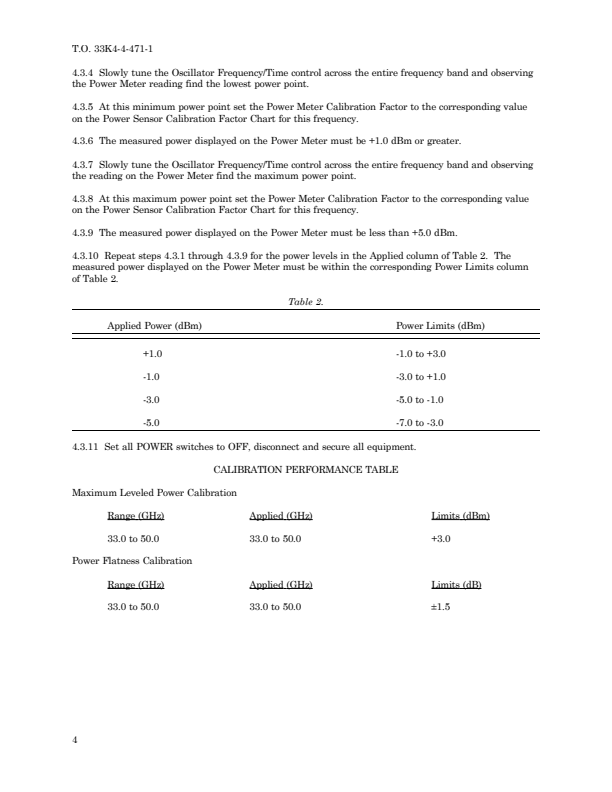

In [8]:
bitmap = page.render(
    scale = 1,    # 72dpi resolution
    rotation = 0, # no additional rotation
    # ... further rendering options
)
pil_image = bitmap.to_pil()
image_copy=pil_image.copy()
pil_image

(2323, 1772, 3)


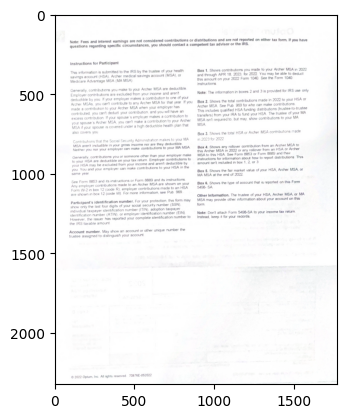

In [9]:
image_filepath=os.path.join(DATAPATH,image_filename)
image=cv2.imread(image_filepath)
print(image.shape)
plt.imshow(image)

In [ ]:
pdfs = glob.glob(f"{DATAPATH}/*.pdf")
pdfs

['drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/sv600_g_fine.pdf',
 'drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/Scanned Pdf For Reading Text.pdf',
 'drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/Sample_Scanned_PDF.pdf',
 'drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/invoice.pdf']

In [13]:
im_file='Optum Financial® 2.jpeg'
im_filepath=os.path.join(DATAPATH,im_file)
im=Image.open(im_filepath)
print(im.format, im.size, im.mode, type(im))
#im.rotate(180).show() #rotate an image
im.show()

JPEG (1772, 2323) RGB <class 'PIL.JpegImagePlugin.JpegImageFile'>


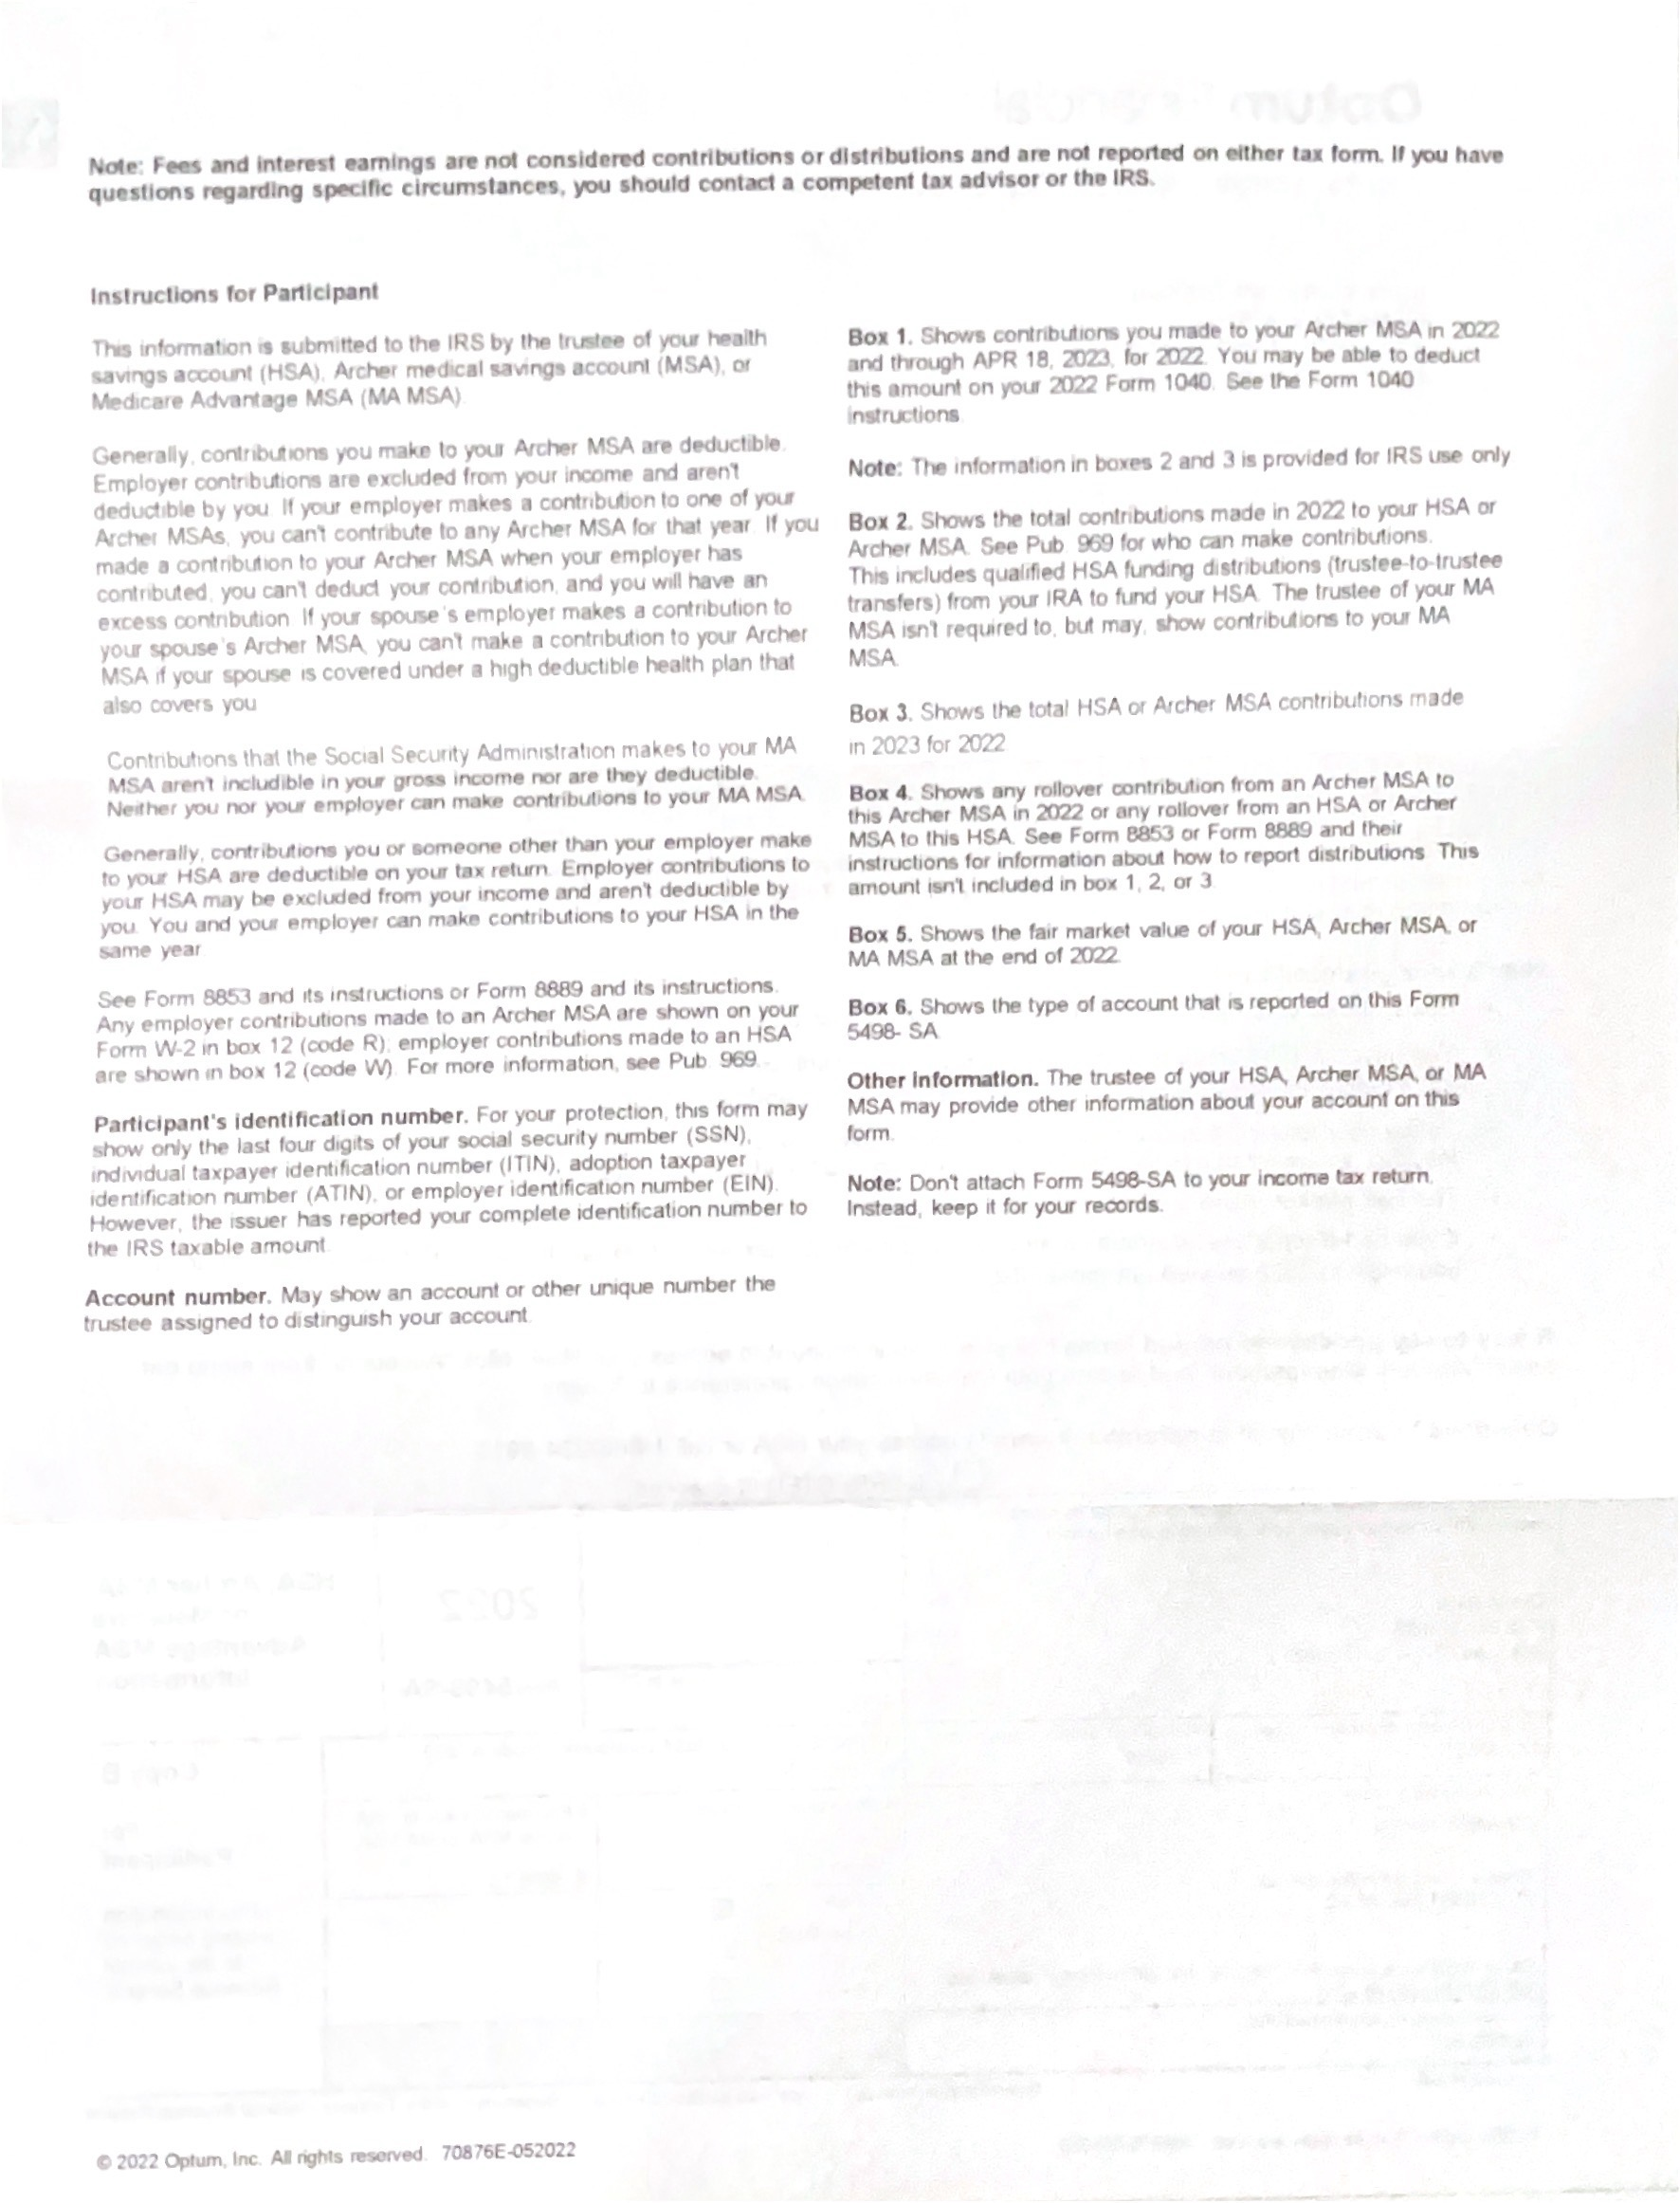

In [13]:
im

## Read models

## Preprocess data

In [11]:
def display_image(image,cmap='gray'):
    '''
    Displays opencv images in matplotlib
    '''
    dpi=80
    height,width=image.shape[:2]
    figsize=(width/float(dpi),height/float(dpi))
    fig=plt.figure(figsize=figsize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax=fig.add_subplot(111)
    ax.imshow(image,cmap=cmap)
    plt.show()


def grayscale(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

def noise_removal(image,dilation_kernel,erosion_kernel,iterations):
    kernel = np.ones((dilation_kernel, dilation_kernel), np.uint8)
    image = cv2.dilate(image, kernel, iterations=iterations) #expansion of pixels

    kernel = np.ones((erosion_kernel, erosion_kernel), np.uint8)
    image = cv2.erode(image, kernel, iterations=iterations) #thinning of pixels

    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)


def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    if len(newImage.shape)>2:
        newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(newImage, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle


# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)


def remove_borders(image):
    if len(image.shape)>2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, heiarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

## Extract content from pdf

#### Pytesseract


In [ ]:
#using Pytesseract - images to text files

imgs_path=os.path.join(DATAPATH,imgs)
for pdf_path in pdfs:
  print(pdf_path)
  pages = convert_from_path(pdf_path, 500)

  for pageNum,imgBlob in enumerate(pages):
    text = pytesseract.image_to_string(imgBlob,lang='eng')

    with open(f'{pdf_path[:-4]}_page{pageNum}.txt', 'w') as the_file:
        the_file.write(text)

drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/sv600_g_fine.pdf
drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/Scanned Pdf For Reading Text.pdf
drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/Sample_Scanned_PDF.pdf
drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/invoice.pdf


#### Marker

In [15]:
from marker.converters.pdf import PdfConverter
from marker.models import create_model_dict
from marker.config.parser import ConfigParser
from marker.output import text_from_rendered

In [ ]:
start_time=time.time()
config = {
    "output_format": "json",
    "ADDITIONAL_KEY": "VALUE",
    # "use_llm": True
}
config_parser = ConfigParser(config)

converter = PdfConverter(
    config=config_parser.generate_config_dict(),
    artifact_dict=create_model_dict(),
    processor_list=config_parser.get_processors(),
    renderer=config_parser.get_renderer(),
)
end_time=time.time()
print(f"\nTime taken: {end_time-start_time}")

Loaded layout model datalab-to/surya_layout on device cuda with dtype torch.float16
Loaded texify model to cuda with torch.float16 dtype
Loaded recognition model vikp/surya_rec2 on device cuda with dtype torch.float16
Loaded table recognition model vikp/surya_tablerec on device cuda with dtype torch.float16
Loaded detection model vikp/surya_det3 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]
Recognizing equations: 0it [00:00, ?it/s]
Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

Time taken: 38.03733968734741


In [ ]:
%%time
rendered = converter(pdf_filepath)
text, table, images = text_from_rendered(rendered)

In [ ]:
rendered

JSONOutput(children=[JSONBlockOutput(id='/page/0/Page/122', block_type='Page', html="<content-ref src='/page/0/SectionHeader/0'></content-ref><content-ref src='/page/0/Text/1'></content-ref><content-ref src='/page/0/Text/2'></content-ref><content-ref src='/page/0/Text/3'></content-ref><content-ref src='/page/0/Text/12'></content-ref><content-ref src='/page/0/Picture/4'></content-ref><content-ref src='/page/0/Picture/5'></content-ref><content-ref src='/page/0/Table/6'></content-ref><content-ref src='/page/0/Text/7'></content-ref><content-ref src='/page/0/Table/8'></content-ref><content-ref src='/page/0/SectionHeader/9'></content-ref><content-ref src='/page/0/Text/10'></content-ref><content-ref src='/page/0/Text/11'></content-ref>", polygon=[[0.0, 0.0], [612.0, 0.0], [612.0, 792.0], [0.0, 792.0]], children=[JSONBlockOutput(id='/page/0/SectionHeader/0', block_type='SectionHeader', html='<h2>Stanford Plumbing &amp; Heating</h2>', polygon=[[54.0, 61.53662109375], [309.0, 61.53662109375], [3

In [ ]:
text

'{\n  "children": [\n    {\n      "id": "/page/0/Page/122",\n      "block_type": "Page",\n      "html": "<content-ref src=\'/page/0/SectionHeader/0\'></content-ref><content-ref src=\'/page/0/Text/1\'></content-ref><content-ref src=\'/page/0/Text/2\'></content-ref><content-ref src=\'/page/0/Text/3\'></content-ref><content-ref src=\'/page/0/Text/12\'></content-ref><content-ref src=\'/page/0/Picture/4\'></content-ref><content-ref src=\'/page/0/Picture/5\'></content-ref><content-ref src=\'/page/0/Table/6\'></content-ref><content-ref src=\'/page/0/Text/7\'></content-ref><content-ref src=\'/page/0/Table/8\'></content-ref><content-ref src=\'/page/0/SectionHeader/9\'></content-ref><content-ref src=\'/page/0/Text/10\'></content-ref><content-ref src=\'/page/0/Text/11\'></content-ref>",\n      "polygon": [\n        [\n          0.0,\n          0.0\n        ],\n        [\n          612.0,\n          0.0\n        ],\n        [\n          612.0,\n          792.0\n        ],\n        [\n          0.0

In [ ]:
table

'json'

In [ ]:
images

{}

In [ ]:
len(rendered.children.images)

AttributeError: 'list' object has no attribute 'images'

In [ ]:


# Convert the data to a JSON formatted string with 4 spaces of indentation
json_str = json.dumps(rendered.children, indent=2)

# Print the pretty-printed JSON string
print(json_str)

TypeError: Object of type JSONBlockOutput is not JSON serializable

In [ ]:
start_time=time.time()
config = {
    "output_format": "json",
    "ADDITIONAL_KEY": "VALUE"
}
config_parser = ConfigParser(config)

converter = PdfConverter(
    config=config_parser.generate_config_dict(),
    artifact_dict=create_model_dict(),
    processor_list=config_parser.get_processors(),
    renderer=config_parser.get_renderer()
    use_llm=True
)
rendered = converter(pdf_filepath)
text, table, images = text_from_rendered(rendered)
end_time=time.time()
print(f"Time taken: {end_time-start_time}")

#### Surya

##### Layout Analysis

In [10]:
from surya.detection import batch_text_detection
from surya.layout import batch_layout_detection
from surya.model.detection.model import load_model as load_det_model, load_processor as load_det_processor
from surya.model.layout.model import load_model as load_layout_model
from surya.model.layout.processor import load_processor as load_layout_processor
from surya.tables import batch_table_recognition
from surya.postprocessing.util import rescale_bboxes, rescale_bbox

In [12]:
%%time
model = load_layout_model()
processor = load_layout_processor()
det_model = load_det_model()
det_processor = load_det_processor()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/253M [00:00<?, ?B/s]

Loaded layout model datalab-to/surya_layout on device cpu with dtype torch.float32


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/154M [00:00<?, ?B/s]

Loaded detection model vikp/surya_det3 on device cpu with dtype torch.float32


preprocessor_config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

CPU times: user 2.33 s, sys: 1.72 s, total: 4.04 s
Wall time: 15.5 s


In [26]:
%%time
# layout_predictions is a list of dicts, one per image
line_predictions = batch_text_detection([pil_image], det_model, det_processor)
layout_predictions = batch_layout_detection([pil_image], model, processor, line_predictions)

Recognizing layout: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

CPU times: user 14.9 s, sys: 3.84 s, total: 18.7 s
Wall time: 19 s


In [14]:
layout_predictions

[LayoutResult(bboxes=[LayoutBox(polygon=[[71.35532382130623, 42.97807466983795], [154.4913318157196, 42.97807466983795], [154.4913318157196, 53.9814847111702], [71.35532382130623, 53.9814847111702]], confidence=0.9406486749649048, label='SectionHeader', position=0, top_k={'SectionHeader': 0.9406486749649048, 'Text': 0.0589597187936306, 'PageHeader': 0.0003621227224357426, 'TextInlineMath': 1.156737835117383e-05, 'Table': 7.065003501338651e-06}, bbox=[71.35532382130623, 42.97807466983795, 154.4913318157196, 53.9814847111702]), LayoutBox(polygon=[[71.1526654958725, 67.13410592079163], [534.8720669746399, 67.13410592079163], [534.8720669746399, 89.30160641670227], [71.1526654958725, 89.30160641670227]], confidence=0.9999786615371704, label='Text', position=1, top_k={'Text': 0.9999786615371704, 'SectionHeader': 1.0291667422279716e-05, 'Form': 3.1277040761779062e-06, 'TextInlineMath': 2.8201209261169424e-06, 'Table': 1.3458336525218328e-06}, bbox=[71.1526654958725, 67.13410592079163, 534.87

In [15]:
len(layout_predictions[0].bboxes)

14

In [16]:
id=0
for bbox in layout_predictions[0].bboxes:
  print(f"{bbox.position}: {bbox.label},  {bbox.bbox}")
  id+=1

0: SectionHeader,  [71.35532382130623, 42.97807466983795, 154.4913318157196, 53.9814847111702]
1: Text,  [71.1526654958725, 67.13410592079163, 534.8720669746399, 89.30160641670227]
2: Text,  [71.29018771648407, 101.02974236011505, 529.0532355308533, 123.78555858135223]
3: Text,  [71.3783004283905, 135.35774660110474, 461.7883086204529, 146.03615498542786]
4: Text,  [71.16353595256805, 159.38616585731506, 535.3400073051453, 181.64895343780518]
5: Text,  [71.22753667831421, 193.6729348897934, 530.8030872344971, 215.47681260108948]
6: Text,  [71.27382731437683, 227.7175326347351, 457.8060371875763, 237.98904132843018]
7: Text,  [71.19808065891266, 250.34159445762634, 529.4590902328491, 283.6138050556183]
8: Table,  [73.53024959564209, 302.62401509284973, 538.0862567424774, 430.30552196502686]
9: Text,  [71.25115621089935, 441.64371728897095, 416.4643406867981, 451.83794832229614]
10: SectionHeader,  [212.00230371952057, 465.5653781890869, 399.8993697166443, 474.59095573425293]
11: Text,  

In [17]:
ID_TO_LABEL = {
    0: 'Blank',
    1: 'Text',
    2: 'TextInlineMath',
    3: 'Code',
    4: 'SectionHeader',
    5: 'Caption',
    6: 'Footnote',
    7: 'Equation',
    8: 'ListItem',
    9: 'PageFooter',
    10: 'PageHeader',
    11: 'Picture',
    12: 'Figure',
    13: 'Table',
    14: 'Form',
    15: 'TableOfContents',
    16: 'Handwriting'
}

LABEL_TO_ID = {v: k for k, v in ID_TO_LABEL.items()}
LABEL_COUNT = len(ID_TO_LABEL)
LABEL_COUNT, LABEL_TO_ID

(17,
 {'Blank': 0,
  'Text': 1,
  'TextInlineMath': 2,
  'Code': 3,
  'SectionHeader': 4,
  'Caption': 5,
  'Footnote': 6,
  'Equation': 7,
  'ListItem': 8,
  'PageFooter': 9,
  'PageHeader': 10,
  'Picture': 11,
  'Figure': 12,
  'Table': 13,
  'Form': 14,
  'TableOfContents': 15,
  'Handwriting': 16})

In [18]:
import random

number_of_colors = LABEL_COUNT
COLOR_MAP={}
for key,_ in LABEL_TO_ID.items():
  COLOR_MAP[key]=f"#{''.join([random.choice('0123456789ABCDEF') for j in range(6)])}"
COLOR_MAP

{'Blank': '#E4C801',
 'Text': '#A71554',
 'TextInlineMath': '#7A1E93',
 'Code': '#7BCF33',
 'SectionHeader': '#0E12CE',
 'Caption': '#C61110',
 'Footnote': '#8B8E3B',
 'Equation': '#E34937',
 'ListItem': '#ECE20F',
 'PageFooter': '#83CE29',
 'PageHeader': '#2F5297',
 'Picture': '#712860',
 'Figure': '#177036',
 'Table': '#D35325',
 'Form': '#EC14C0',
 'TableOfContents': '#F42835',
 'Handwriting': '#49EF2D'}

In [19]:
image_copy=pil_image.copy()

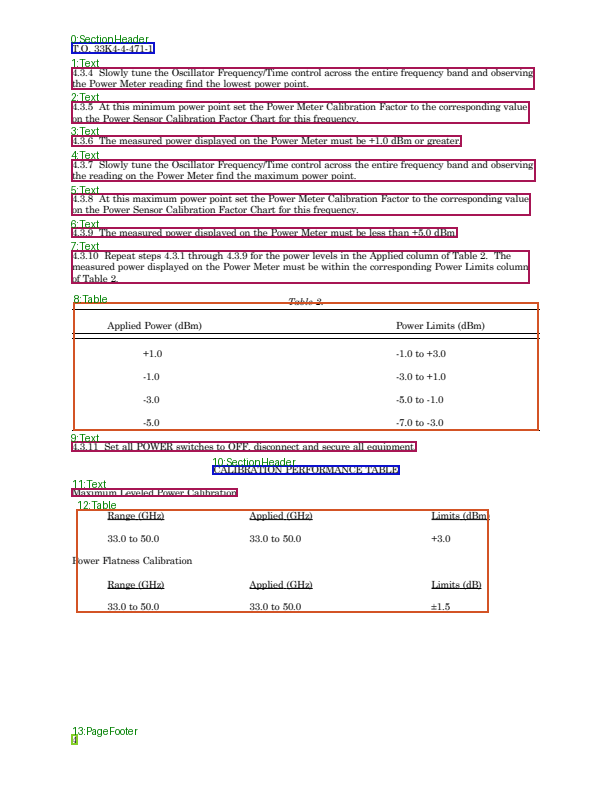

In [20]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

draw = ImageDraw.Draw(image_copy)
for bbox in layout_predictions[0].bboxes:
  draw.rectangle(tuple(bbox.bbox), outline=COLOR_MAP[bbox.label], width=2)
  draw.text([bbox.polygon[0][0],bbox.polygon[0][1]-10],text=f'{bbox.position}:{bbox.label}',fill='green')#, font=ImageFont.truetype("font_path123"))
image_copy

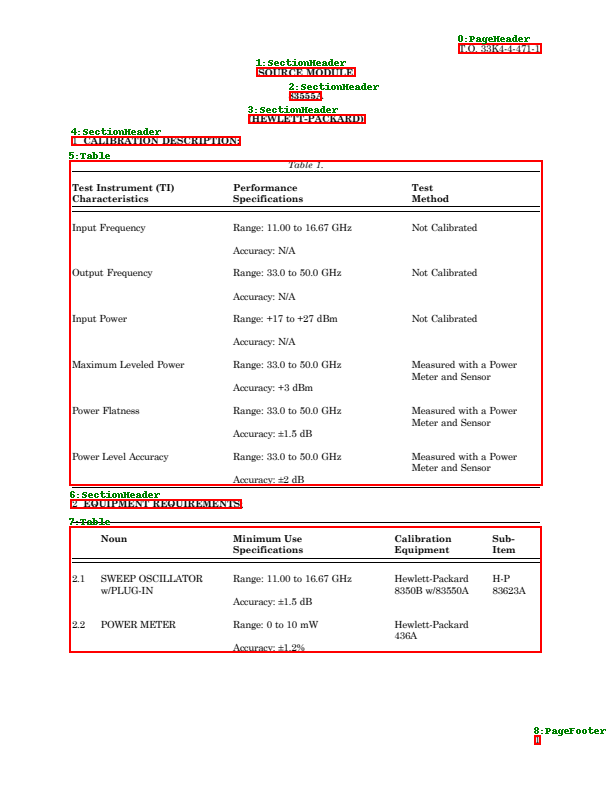

In [84]:
draw = ImageDraw.Draw(image_copy)

for bbox in layout_predictions[0].bboxes:
  draw.rectangle(tuple(bbox.bbox), outline='red', width=2)
  draw.text([bbox.polygon[0][0],bbox.polygon[0][1]-10], f'{bbox.position}:{bbox.label}','green')#, font=ImageFont.truetype("font_path123"))

image_copy

In [114]:
%%time
# layout_predictions is a list of dicts, one per image
line_predictions = batch_text_detection([pil_image], det_model, det_processor)
layout_predictions = batch_layout_detection([pil_image], model, processor, line_predictions)

Recognizing layout: 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]

CPU times: user 15.3 s, sys: 3.79 s, total: 19.1 s
Wall time: 20 s


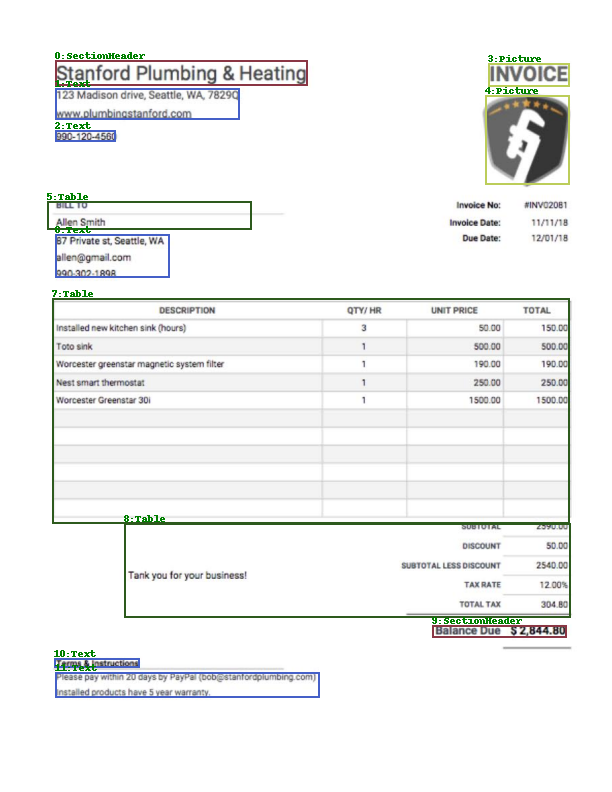

In [117]:
draw = ImageDraw.Draw(image_copy)
for bbox in layout_predictions[0].bboxes:
  draw.rectangle(tuple(bbox.bbox), outline=COLOR_MAP[bbox.label], width=2)#fill="black")
  draw.text([bbox.polygon[0][0],bbox.polygon[0][1]-10],text=f'{bbox.position}:{bbox.label}',fill='green')#, font=ImageFont.truetype("font_path123"))
image_copy

In [123]:
id=0
for bbox in layout_predictions[0].bboxes:
  print(f"{id}: {bbox.label}, {bbox.position}: {bbox.bbox}")
  id+=1

0: SectionHeader, 0: [55.76795071363449, 60.95056539773941, 307.0945601463318, 85.43972378969193]
1: Text, 1: [55.79080420732498, 88.2340641617775, 239.44701504707336, 119.13526797294617]
2: Text, 2: [55.298232078552246, 130.99711740016937, 115.74938893318176, 141.83867275714874]
3: Picture, 3: [488.84779357910156, 63.1794735789299, 569.4857897758484, 86.87355011701584]
4: Picture, 4: [485.23880195617676, 95.31841814517975, 569.9648923873901, 184.8401974439621]
5: Table, 5: [47.86382460594177, 201.59588956832886, 251.81522369384766, 229.42755460739136]
6: Text, 6: [55.96332710981369, 234.5839855670929, 169.37568640708923, 277.90314173698425]
7: Table, 7: [52.526247382164, 298.0132484436035, 569.5604238510132, 523.5815935134888]
8: Table, 8: [124.27868485450745, 523.3153939247131, 570.4505245685577, 617.9252486228943]
9: SectionHeader, 9: [432.8512258529663, 625.5627551078796, 566.5673274993896, 637.4603991508484]
10: Text, 10: [54.81532207131386, 658.9538798332214, 139.4837361574173, 6

In [22]:
print(type(image))
color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(color_coverted)
type(image)

<class 'numpy.ndarray'>


PIL.Image.Image

In [23]:

# layout_predictions is a list of dicts, one per image
line_predictions = batch_text_detection([image], det_model, det_processor)
layout_predictions = batch_layout_detection([image], model, processor, line_predictions)

Recognizing layout: 100%|██████████| 1/1 [00:26<00:00, 26.28s/it]


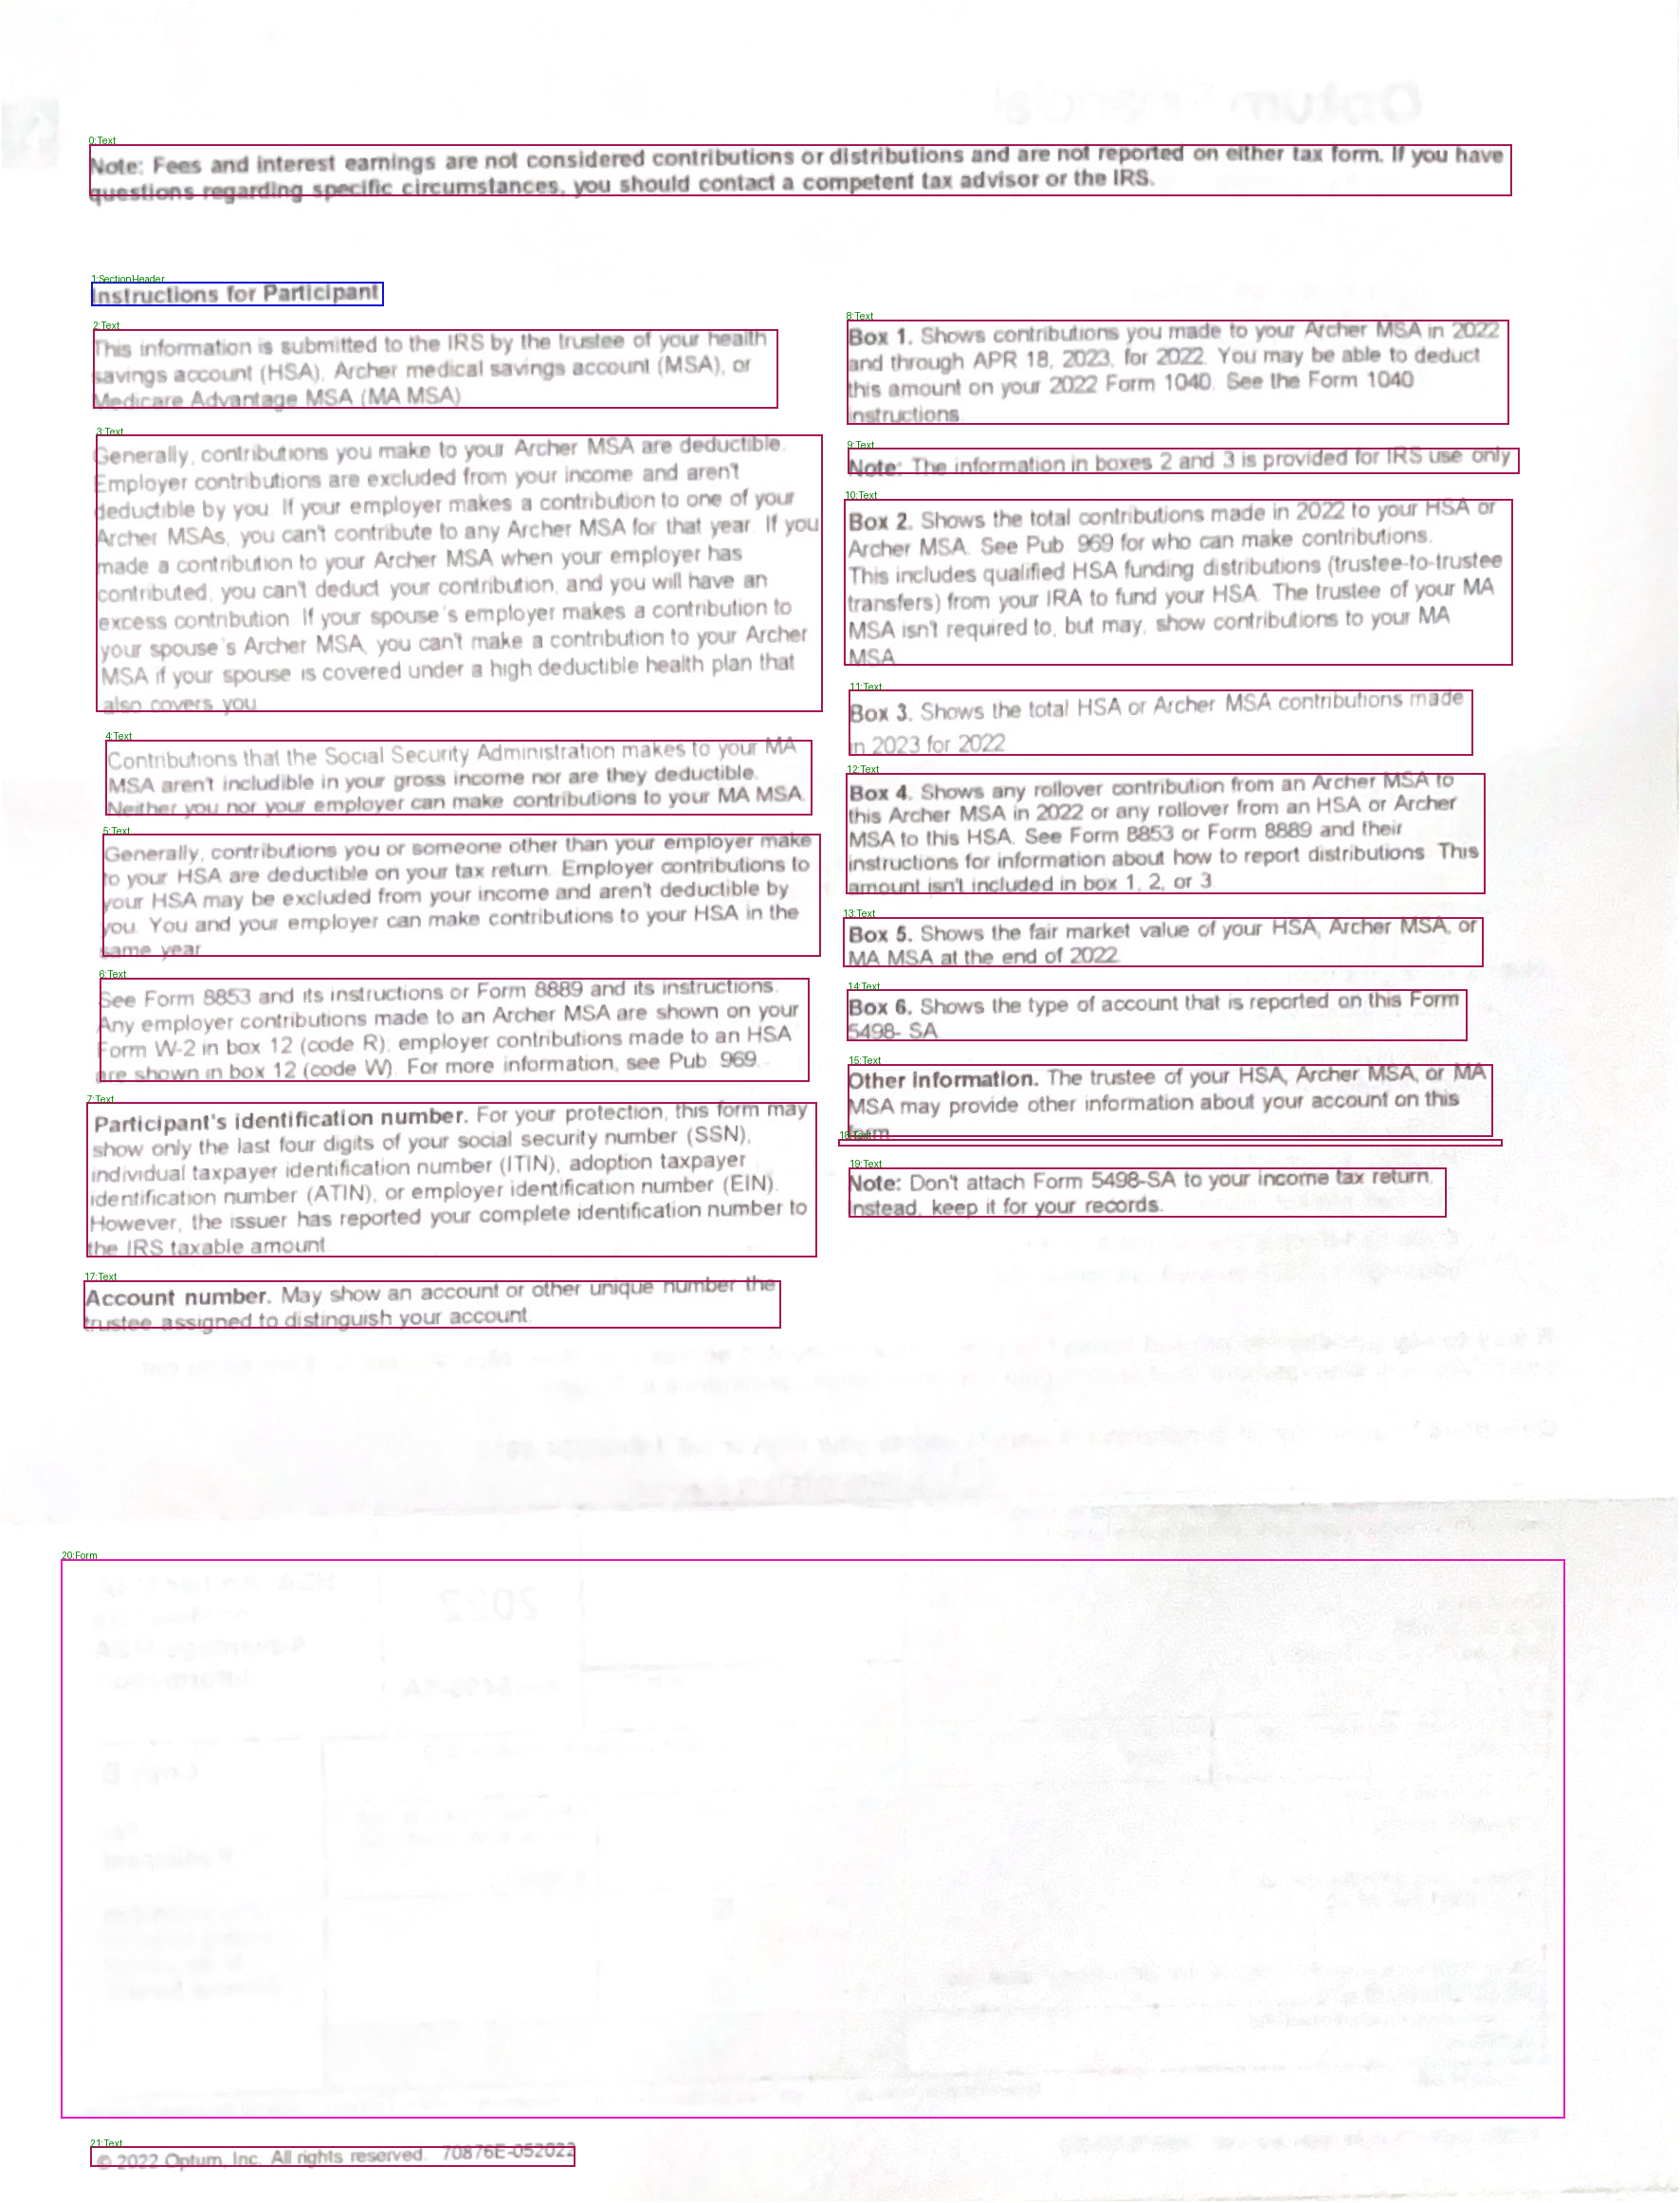

In [24]:
image_copy=image.copy()
draw = ImageDraw.Draw(image_copy)
for bbox in layout_predictions[0].bboxes:
  draw.rectangle(tuple(bbox.bbox), outline=COLOR_MAP[bbox.label], width=2)#fill="black")
  draw.text([bbox.polygon[0][0],bbox.polygon[0][1]-10],text=f'{bbox.position}:{bbox.label}',fill='green')#, font=ImageFont.truetype("font_path123"))
image_copy

In [27]:
structure={}
for bbox in layout_predictions[0].bboxes:
  if bbox.label not in structure:
    structure[bbox.label]={}

  structure[bbox.label][bbox.position]={}
  structure[bbox.label][bbox.position]['bbox']=bbox.bbox
  structure[bbox.label][bbox.position]['polygon']=bbox.polygon
  structure[bbox.label][bbox.position]['confidence']=bbox.confidence
structure

{'SectionHeader': {0: {'bbox': [71.35532382130623,
    42.97807466983795,
    154.4913318157196,
    53.9814847111702],
   'polygon': [[71.35532382130623, 42.97807466983795],
    [154.4913318157196, 42.97807466983795],
    [154.4913318157196, 53.9814847111702],
    [71.35532382130623, 53.9814847111702]],
   'confidence': 0.9406486749649048},
  10: {'bbox': [212.00230371952057,
    465.5653781890869,
    399.8993697166443,
    474.59095573425293],
   'polygon': [[212.00230371952057, 465.5653781890869],
    [399.8993697166443, 464.0185031890869],
    [399.8993697166443, 474.59095573425293],
    [212.00230371952057, 476.13783073425293]],
   'confidence': 0.9999508857727051}},
 'Text': {1: {'bbox': [71.1526654958725,
    67.13410592079163,
    534.8720669746399,
    89.30160641670227],
   'polygon': [[71.1526654958725, 67.13410592079163],
    [534.8720669746399, 67.13410592079163],
    [534.8720669746399, 89.30160641670227],
    [71.1526654958725, 89.30160641670227]],
   'confidence': 0.99

##### Table Recognition & OCR

In [25]:
from surya.input.load import load_from_file
from surya.model.table_rec.model import load_model as load_model
from surya.model.table_rec.processor import load_processor
from surya.tables import batch_table_recognition
from surya.model.detection.model import load_model as load_det_model, load_processor as load_det_processor
from surya.model.layout.model import load_model as load_layout_model
from surya.model.layout.processor import load_processor as load_layout_processor
from surya.input.pdflines import get_table_blocks
from surya.detection import batch_text_detection
# from surya.postprocessing.util import rescale_bboxes, rescale_bbox

In [28]:
text_labels={'Text','SectionHeader','Footnote','TextInlineMath',
             'Code','Caption','Equation','PageFooter','PageHeader',
             'ListItem','Form',}

pad_size=30
buffer_space=2
cv_image=np.asarray(pil_image).copy()

In [29]:
snippets=[]

def get_image_countours(image,bounding_box,pad_size=30,buffer_space=5):
    height,width,depth=image.shape
    x, y, w, h=bounding_box
    roi = image[max(0,y-buffer_space):min(y+h+buffer_space,height),
                max(0,x-buffer_space):min(x+w+buffer_space,width)]

    constant= cv2.copyMakeBorder(roi.copy(),pad_size,pad_size,pad_size,pad_size,cv2.BORDER_CONSTANT,value=[255,255,255])

    # constant= cv2.copyMakeBorder(roi.copy(),pad_size,pad_size,pad_size,pad_size,cv2.BORDER_REPLICATE)
    snippets.append(constant)
    return constant


def get_text_from_image(image):
    ocr_result = pytesseract.image_to_string(image)
    return ocr_result


for bbox in layout_predictions[0].bboxes:
  if bbox.label in text_labels:
    bounding_box = (int(bbox.polygon[0][0]), int(bbox.polygon[0][1]), int(bbox.width), int(bbox.height))
    image_box=get_image_countours(cv_image,bounding_box,pad_size=pad_size,buffer_space=buffer_space)
    ocr_result=get_text_from_image(image_box)
    # print(f'{bbox.label}, {bbox.position}: {ocr_result}')
    structure[bbox.label][bbox.position]['text']=ocr_result
    print(f'{bbox.label}, {bbox.position}: {ocr_result}')

print(structure)

SectionHeader, 0: TO, sak4taTL

Text, 1: 43.4 Slowly tune the Oscillator Frequency/Time control across the entire frequency band and observing
the Power Meter reading find the lowest power point

Text, 2: 435 At this minimum power point set the Power Meter Calibration Factor tothe corresponding vale
‘on the Power Sensor Calibration Factor Chart for this frequency.

Text, 3: 43.6 The measured power displayed on the Power Meter must be +.0 dBim or greater.

Text, 4: 437 Slowly tune the Oscillatr Frequency/Time control across the entire frequency band and observing
‘the reading n the Power Meter find the maximum power point.

Text, 5: 4438 At this maximum power pont set the Power Meter Calibration Factor to the corresponding value
‘on the Power Sensor Calibration Factor Chart for this fequeney.

Text, 6: 43.9 The measured power displayed on the Power Meter must be less than +50 dB,

Text, 7: 443.10 Repeat steps 4.1 through 43.9 for the power level in the Applicd column of Table 2. 

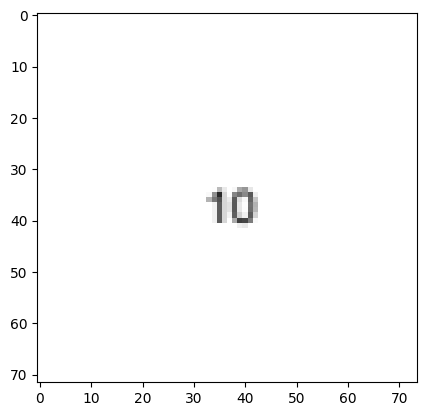

In [27]:
plt.imshow(snippets[4])

In [30]:
snaps=set([key for key in set(COLOR_MAP.keys()) if key not in text_labels])
snaps

{'Blank', 'Figure', 'Handwriting', 'Picture', 'Table', 'TableOfContents'}

In [31]:
snaps_not_text=[]
for bbox in layout_predictions[0].bboxes:
  if bbox.label in snaps:
    bounding_box = (int(bbox.polygon[0][0]), int(bbox.polygon[0][1]), int(bbox.width), int(bbox.height))
    image_box=get_image_countours(cv_image,bounding_box,pad_size=pad_size,buffer_space=buffer_space)
    snaps_not_text.append(image_box)
len(snaps_not_text)

2

In [32]:

def get_name_from_path(path):
    return os.path.basename(path).split(".")[0]


def rescale_bbox_with_buffer(bbox, buffer_size=2):
    # page_width, page_height = processor_size

    # img_width, img_height = image_size
    # width_scaler = img_width / page_width
    # height_scaler = img_height / page_height

    new_bbox = copy.deepcopy(bbox)
    # new_bbox[0] = int(new_bbox[0] * width_scaler-buffer_space)
    # new_bbox[1] = int(new_bbox[1] * height_scaler-buffer_space)
    # new_bbox[2] = int(new_bbox[2] * width_scaler+buffer_space)
    # new_bbox[3] = int(new_bbox[3] * height_scaler+buffer_space)

    new_bbox[0] = int(new_bbox[0] -buffer_size)
    new_bbox[1] = int(new_bbox[1] -buffer_size)
    new_bbox[2] = int(new_bbox[2] +buffer_size)
    new_bbox[3] = int(new_bbox[3] +buffer_size)
    return new_bbox


names=[get_name_from_path(pdf_filepath)]
names

['Sample-Cert_rev-7-1']

In [34]:
!pwd

/content


In [44]:
import copy
import json
from collections import defaultdict

from surya.model.table_rec.model import load_model as load_model
from surya.model.table_rec.processor import load_processor
from surya.postprocessing.heatmap import draw_bboxes_on_image



def load_models(model_tag):
    if model_tag=='surya':
        layout_model = load_layout_model()
        layout_processor = load_layout_processor()
        det_model = load_det_model()
        det_processor = load_det_processor()

        table_rec_model = load_model()
        tables_processor = load_processor()
        return (layout_model, layout_processor, det_model,
                det_processor, table_rec_model, tables_processor)
    return None


def draw_table_bounding_boxes(table_img, pred):
    '''
    Draws rows and cell bounding boxes on the table image. Returns the two images
    '''

    rows = [l.bbox for l in pred.rows]
    cols = [l.bbox for l in pred.cols]
    row_labels = [f"Row {l.row_id}" for l in pred.rows]
    col_labels = [f"Col {l.col_id}" for l in pred.cols]
    cells = [l.bbox for l in pred.cells]

    rc_image = copy.deepcopy(table_img)
    rc_image = draw_bboxes_on_image(rows, rc_image, labels=row_labels, label_font_size=20, color="blue")
    rc_image = draw_bboxes_on_image(cols, rc_image, labels=col_labels, label_font_size=20, color="red")

    cell_image = copy.deepcopy(table_img)
    cell_image = draw_bboxes_on_image(cells, cell_image, color="green")

    return rc_image, cell_image


def save_image(image, image_filename):
    image.save(image_filename)


def save_to_file(table_predictions, result_path, output_file_type='json'):
    if output_file_type == "json":
        with open(result_path, "w+", encoding="utf-8") as f:
            json.dump(table_predictions, f, ensure_ascii=False)

def table_recognition_from_images(input_filepath, pil_image, layout_predictions, result_path, model_tag='surya'):

    _,_, det_model, det_processor, table_rec_model, tables_processor = load_models(model_tag)

    names=[get_name_from_path(input_filepath)]
    pnums = []
    prev_name = None
    for i, name in enumerate(names):
        if prev_name is None or prev_name != name:
            pnums.append(0)
        else:
            pnums.append(pnums[-1] + 1)

        prev_name = name

    table_imgs=[]
    table_counts=[]
    table_cells=[]
    buffer_size=3
    images, highres_images = [pil_image.copy()], [pil_image.copy()]

    # crop table snaps from each layout object
    for layout_pred, img, highres_img in zip(layout_predictions, images, highres_images):
        # The bbox for the entire table
        bbox = [l.bbox for l in layout_pred.bboxes if l.label in {'Table','TableOfContents'}]
        # Number of tables per page
        table_counts.append(len(bbox))

        if len(bbox) == 0:
          continue

        page_table_imgs = []
        highres_bbox = []
        for bb in bbox:
            highres_bb = rescale_bbox_with_buffer(bb,buffer_size)
            page_table_imgs.append(highres_img.crop(highres_bb))
            highres_bbox.append(highres_bb)

        table_imgs.extend(page_table_imgs)
        det_results = batch_text_detection(page_table_imgs, det_model, det_processor)
        cell_bboxes = [[{"bbox": tb.bbox, "text": None} for tb in det_result.bboxes] for det_result in det_results]
        table_cells.extend(cell_bboxes)

    table_preds = batch_table_recognition(table_imgs, table_cells, table_rec_model, tables_processor)
    os.makedirs(result_path, exist_ok=True)

    img_idx = 0
    prev_count = 0
    table_predictions = defaultdict(list)
    folder_name='results_surya_lib'
    result_path = os.path.join(DATAPATH, folder_name)
    os.makedirs(result_path, exist_ok=True)
    save_images=True

    for i in range(sum(table_counts)):
        while i >= prev_count + table_counts[img_idx]:
            prev_count += table_counts[img_idx]
            img_idx += 1

        pred = table_preds[i]
        orig_name = names[img_idx]
        pnum = pnums[img_idx]
        table_img = table_imgs[i]

        out_pred = pred.model_dump()
        out_pred["page"] = pnum + 1
        table_idx = i - prev_count
        out_pred["table_idx"] = table_idx
        table_predictions[orig_name].append(out_pred)

        if save_images:
            rc_image,cell_image=draw_table_bounding_boxes(table_img, pred)
            save_image(rc_image, os.path.join(result_path, f"{name}_page{pnum + 1}_table{table_idx}_rc.png"))
            save_image(cell_image, os.path.join(result_path, f"{name}_page{pnum + 1}_table{table_idx}_cells.png"))

    return table_predictions



In [43]:
%%time
folder_name='results_surya_lib'
json_folder_name='json_files'
result_path = os.path.join(DATAPATH, folder_name)
table_predictions=table_recognition_from_images(pdf_filepath, pil_image, layout_predictions,result_path,model_tag='surya')
json_file_path=os.path.join(DATAPATH,json_folder_name,'results.json')

save_to_file(table_predictions, json_file_path, output_file_type='json')


Loaded layout model datalab-to/surya_layout on device cpu with dtype torch.float32
Loaded detection model vikp/surya_det3 on device cpu with dtype torch.float32
Loaded table recognition model vikp/surya_tablerec on device cpu with dtype torch.float32


Recognizing tables: 100%|██████████| 1/1 [00:11<00:00, 11.54s/it]


CPU times: user 27.1 s, sys: 8.02 s, total: 35.1 s
Wall time: 37.1 s


In [31]:
pnums = []
prev_name = None
for i, name in enumerate(names):
    if prev_name is None or prev_name != name:
        pnums.append(0)
    else:
        pnums.append(pnums[-1] + 1)

    prev_name = name
pnums

[0]

In [32]:
images, highres_images = [pil_image.copy()], [pil_image.copy()]
highres_images[0].size

(792, 613)

In [36]:
table_imgs=[]
table_counts=[]
table_cells=[]
buffer_size=3
# crop table snaps from each layout object
for layout_pred, img, highres_img in zip(layout_predictions, images, highres_images):
    # The bbox for the entire table
    bbox = [l.bbox for l in layout_pred.bboxes if l.label in {'Table','TableOfContents'}]
    # Number of tables per page
    table_counts.append(len(bbox))

    if len(bbox) == 0:
      continue

    page_table_imgs = []
    highres_bbox = []
    for bb in bbox:
        highres_bb = rescale_bbox_with_buffer(bb,buffer_size)
        page_table_imgs.append(highres_img.crop(highres_bb))
        highres_bbox.append(highres_bb)

    table_imgs.extend(page_table_imgs)

print(len(table_imgs),table_counts, page_table_imgs, highres_bbox)

1 [1] [<PIL.Image.Image image mode=RGB size=676x379 at 0x7F4B701329E0>] [[70, 134, 746, 513]]


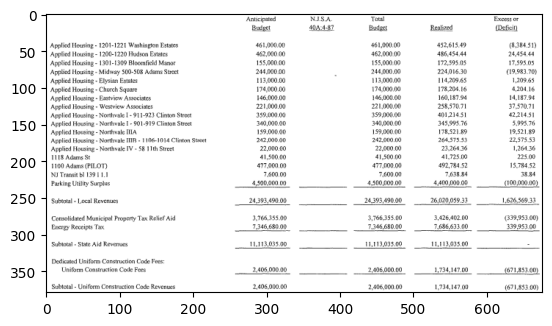

In [37]:
plt.imshow(page_table_imgs[0])

In [114]:
%%time
det_results = batch_text_detection(page_table_imgs, det_model, det_processor,)
# cell_bboxes = [[{"bbox": tb.bbox, "text": None} for tb in det_result.bboxes] for det_result in det_results]

Detecting bboxes: 100%|██████████| 1/1 [00:14<00:00, 14.76s/it]

CPU times: user 8.99 s, sys: 3.07 s, total: 12.1 s
Wall time: 14.8 s


In [123]:
%%time
cell_bboxes=[]
highres_img=page_table_imgs[0]
imgBlobs=[]
for det_result in det_results:
    tmp=[]
    for tb in det_result.bboxes:
        highres_bb = rescale_bbox_with_buffer(tb.bbox,buffer_size=1)
        imgBlob = highres_img.crop(highres_bb)
        imgBlobs.append(imgBlob)
        text = pytesseract.image_to_string(imgBlob,lang='eng')
        tmp.append({"bbox": tb.bbox, "text": text})
    cell_bboxes.append(tmp)
table_cells.extend(cell_bboxes)
table_cells

CPU times: user 464 ms, sys: 99.4 ms, total: 564 ms
Wall time: 26 s


[[{'bbox': [358, 4, 389, 12], 'text': '\x0c'},
  {'bbox': [609, 4, 644, 12], 'text': '\x0c'},
  {'bbox': [271, 4, 314, 12], 'text': '\x0c'},
  {'bbox': [441, 4, 462, 12], 'text': '\x0c'},
  {'bbox': [611, 16, 642, 24], 'text': '\x0c'},
  {'bbox': [279, 16, 306, 24], 'text': '\x0c'},
  {'bbox': [357, 16, 392, 24], 'text': '\x0c'},
  {'bbox': [439, 16, 465, 24], 'text': '\x0c'},
  {'bbox': [522, 16, 554, 24], 'text': '\x0c'},
  {'bbox': [3, 40, 180, 47], 'text': '\x0c'},
  {'bbox': [284, 39, 326, 47], 'text': '\x0c'},
  {'bbox': [441, 40, 483, 47], 'text': '\x0c'},
  {'bbox': [629, 39, 668, 47], 'text': '\x0c'},
  {'bbox': [532, 40, 572, 47], 'text': '\x0c'},
  {'bbox': [4, 52, 166, 59], 'text': '\x0c'},
  {'bbox': [442, 51, 483, 59], 'text': '\x0c'},
  {'bbox': [285, 52, 326, 59], 'text': '\x0c'},
  {'bbox': [532, 52, 572, 59], 'text': '\x0c'},
  {'bbox': [628, 51, 666, 59], 'text': '\x0c'},
  {'bbox': [4, 64, 176, 71], 'text': '\x0c'},
  {'bbox': [285, 63, 327, 71], 'text': '\x0c'},
  

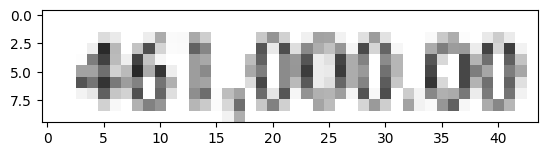

In [131]:
plt.imshow(imgBlobs[10])

In [72]:
%%time
from surya.model.table_rec.model import load_model as load_model
from surya.model.table_rec.processor import load_processor

model = load_model()
processor = load_processor()

config.json:   0%|          | 0.00/8.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/397M [00:00<?, ?B/s]

Loaded table recognition model vikp/surya_tablerec on device cpu with dtype torch.float32


preprocessor_config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

CPU times: user 1.69 s, sys: 1.84 s, total: 3.53 s
Wall time: 12.5 s


In [100]:
%%time
table_preds = batch_table_recognition(table_imgs, table_cells, model, processor)
table_preds

Recognizing tables: 100%|██████████| 1/1 [00:08<00:00,  8.46s/it]

CPU times: user 7.98 s, sys: 208 ms, total: 8.18 s
Wall time: 8.47 s


[TableResult(cells=[TableCell(bbox=[271.0, 4.0, 314.0, 12.0], text=None), TableCell(bbox=[358.0, 4.0, 389.0, 12.0], text=None), TableCell(bbox=[441.0, 4.0, 462.0, 12.0], text=None), TableCell(bbox=[609.0, 4.0, 644.0, 12.0], text=None), TableCell(bbox=[279.0, 16.0, 306.0, 24.0], text=None), TableCell(bbox=[357.0, 16.0, 392.0, 24.0], text=None), TableCell(bbox=[439.0, 16.0, 465.0, 24.0], text=None), TableCell(bbox=[522.0, 16.0, 554.0, 24.0], text=None), TableCell(bbox=[611.0, 16.0, 642.0, 24.0], text=None), TableCell(bbox=[284.0, 39.0, 326.0, 47.0], text=None), TableCell(bbox=[629.0, 39.0, 668.0, 47.0], text=None), TableCell(bbox=[3.0, 40.0, 180.0, 47.0], text=None), TableCell(bbox=[441.0, 40.0, 483.0, 47.0], text=None), TableCell(bbox=[532.0, 40.0, 572.0, 47.0], text=None), TableCell(bbox=[442.0, 51.0, 483.0, 59.0], text=None), TableCell(bbox=[628.0, 51.0, 666.0, 59.0], text=None), TableCell(bbox=[4.0, 52.0, 166.0, 59.0], text=None), TableCell(bbox=[285.0, 52.0, 326.0, 59.0], text=None)

In [2]:
len(table_preds)

NameError: name 'table_preds' is not defined

In [103]:
# out_pred = table_preds[0].model_dump()
for key,val in out_pred.items():
  print(key,len(val))

cells 124
rows 26
cols 6
image_bbox 4


In [104]:
out_pred['image_bbox']

[0.0, 0.0, 676.0, 379.0]

In [1]:
out_pred['cols']

NameError: name 'out_pred' is not defined

In [109]:
out_pred['cells'][:10]

[{'bbox': [271.0, 4.0, 314.0, 12.0], 'text': None},
 {'bbox': [358.0, 4.0, 389.0, 12.0], 'text': None},
 {'bbox': [441.0, 4.0, 462.0, 12.0], 'text': None},
 {'bbox': [609.0, 4.0, 644.0, 12.0], 'text': None},
 {'bbox': [279.0, 16.0, 306.0, 24.0], 'text': None},
 {'bbox': [357.0, 16.0, 392.0, 24.0], 'text': None},
 {'bbox': [439.0, 16.0, 465.0, 24.0], 'text': None},
 {'bbox': [522.0, 16.0, 554.0, 24.0], 'text': None},
 {'bbox': [611.0, 16.0, 642.0, 24.0], 'text': None},
 {'bbox': [284.0, 39.0, 326.0, 47.0], 'text': None}]

In [81]:
table_preds[0].rows

[TableRow(bbox=[270.5517578125, 0.91064453125, 640.2294921875, 8.56005859375], row_id=0),
 TableRow(bbox=[277.421875, 12.0205078125, 641.2109375, 20.7626953125], row_id=1),
 TableRow(bbox=[1.30859375, 35.87939453125, 663.45703125, 43.52880859375], row_id=2),
 TableRow(bbox=[-0.3271484375, 47.7177734375, 661.1669921875, 56.4599609375], row_id=3),
 TableRow(bbox=[0.9814453125, 59.73828125, 662.4755859375, 68.48046875], row_id=4),
 TableRow(bbox=[0.0, 71.39453125, 664.765625, 80.13671875], row_id=5),
 TableRow(bbox=[0.654296875, 83.4150390625, 662.802734375, 92.1572265625], row_id=6),
 TableRow(bbox=[0.9814453125, 95.98193359375, 662.4755859375, 103.63134765625], row_id=7),
 TableRow(bbox=[-0.3271484375, 107.63818359375, 662.4755859375, 115.28759765625], row_id=8),
 TableRow(bbox=[0.654296875, 118.748046875, 661.494140625, 127.490234375], row_id=9),
 TableRow(bbox=[2.2900390625, 130.95068359375, 661.1669921875, 138.60009765625], row_id=10),
 TableRow(bbox=[2.2900390625, 141.87841796875, 6

In [86]:
from collections import defaultdict
from surya.postprocessing.heatmap import draw_bboxes_on_image
import copy

img_idx = 0
prev_count = 0
table_predictions = defaultdict(list)
folder_name='results_surya_lib'
result_path = os.path.join(DATAPATH, folder_name)
os.makedirs(result_path, exist_ok=True)
save_images=True

for i in range(sum(table_counts)):
    while i >= prev_count + table_counts[img_idx]:
        prev_count += table_counts[img_idx]
        img_idx += 1

    pred = table_preds[i]
    orig_name = names[img_idx]
    pnum = pnums[img_idx]
    table_img = table_imgs[i]

    out_pred = pred.model_dump()
    out_pred["page"] = pnum + 1
    table_idx = i - prev_count
    out_pred["table_idx"] = table_idx
    table_predictions[orig_name].append(out_pred)

    if save_images:
        rows = [l.bbox for l in pred.rows]
        cols = [l.bbox for l in pred.cols]
        row_labels = [f"Row {l.row_id}" for l in pred.rows]
        col_labels = [f"Col {l.col_id}" for l in pred.cols]
        cells = [l.bbox for l in pred.cells]

        rc_image = copy.deepcopy(table_img)
        rc_image = draw_bboxes_on_image(rows, rc_image, labels=row_labels, label_font_size=20, color="blue")
        rc_image = draw_bboxes_on_image(cols, rc_image, labels=col_labels, label_font_size=20, color="red")
        rc_image.save(os.path.join(result_path, f"{name}_page{pnum + 1}_table{table_idx}_rc.png"))

        cell_image = copy.deepcopy(table_img)
        cell_image = draw_bboxes_on_image(cells, cell_image, color="green")
        cell_image.save(os.path.join(result_path, f"{name}_page{pnum + 1}_table{table_idx}_cells.png"))

with open(os.path.join(result_path, "results.json"), "w+", encoding="utf-8") as f:
    json.dump(table_predictions, f, ensure_ascii=False)

In [84]:
table_predictions

defaultdict(list,
            {'cafr_city_of_hoboken': [{'cells': [{'bbox': [269.0,
                  1.0,
                  310.0,
                  9.0],
                 'text': None},
                {'bbox': [355.0, 1.0, 386.0, 9.0], 'text': None},
                {'bbox': [438.0, 1.0, 458.0, 9.0], 'text': None},
                {'bbox': [606.0, 1.0, 641.0, 9.0], 'text': None},
                {'bbox': [608.0, 12.0, 639.0, 21.0], 'text': None},
                {'bbox': [276.0, 13.0, 303.0, 21.0], 'text': None},
                {'bbox': [353.0, 13.0, 389.0, 21.0], 'text': None},
                {'bbox': [436.0, 13.0, 462.0, 21.0], 'text': None},
                {'bbox': [519.0, 13.0, 551.0, 21.0], 'text': None},
                {'bbox': [1.0, 36.0, 177.0, 44.0], 'text': None},
                {'bbox': [281.0, 36.0, 323.0, 44.0], 'text': None},
                {'bbox': [438.0, 36.0, 480.0, 44.0], 'text': None},
                {'bbox': [627.0, 36.0, 664.0, 44.0], 'text': None},
    

#### Camelot

In [ ]:
import camelot

print(f"Using camelot v{camelot.__version__}.")

/usr/local/lib/python3.10/dist-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


Using camelot v1.0.0.


In [ ]:

# Set up plotting options
import matplotlib.pyplot as plt

# %matplotlib inline
PLOT_HEIGHT = 12


def init_figure_and_axis(title):
    fig = plt.figure(figsize=(PLOT_HEIGHT * 2.5, PLOT_HEIGHT))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    return fig, ax


# Utility function to display tables
def display_parse_results(tables, parse_time, flavor):
    if not tables:
        return
    tables_dims = ", ".join(
        map(
            lambda table: "{rows}x{cols}".format(
                rows=table.shape[0],
                cols=table.shape[1],
            ),
            tables,
        )
    )
    print(
        f"The {flavor} parser found {len(tables)} table(s) ({tables_dims}) in {parse_time:.2f}s"
    )
    for table in tables:
        display(table.df)

In [ ]:
# Parse file
flavor = "network"
kwargs={}
timer_before_parse = time.perf_counter()
tables = camelot.read_pdf(page, flavor=flavor, debug=True, **kwargs)
timer_after_parse = time.perf_counter()

print(len(tables))
if len(tables):
    fig, ax = init_figure_and_axis(f"Text elements in PDF\n{pdf_filepath}")
    camelot.plot(tables[0], kind="text", ax=ax)
else:
    print("No table found for this document.")

AttributeError: 'PdfPage' object has no attribute 'seek'

In [ ]:
flavor = "lattice"
timer_before_parse = time.perf_counter()
tables = camelot.read_pdf(page, flavor=flavor, debug=True, **kwargs)
timer_after_parse = time.perf_counter()

if len(tables):# is not None:
    fig, ax = init_figure_and_axis(f"Line structure in PDF\n{pdf_filepath}")
    camelot.plot(tables[0], kind="line", ax=ax)
else:
    print("No table found for this document.")

No table found for this document.


In [ ]:
for table in tables:
    fig, ax = init_figure_and_axis(f"Contour structure in PDF\n{pdf_file}")
    camelot.plot(table, kind="contour", ax=ax)

In [ ]:
display_parse_results(tables, timer_after_parse - timer_before_parse, flavor)

#### pymupdf

In [ ]:
import pymupdf

doc = pymupdf.open(pdf_filepath) # open a document
page_number=1
page = doc[page_number] # load a page
text = page.get_text() # get plain text encoded as UTF-8
print(text)

image_list = page.get_images()

# print the number of images found on the page
if image_list:
    print(f"Found {len(image_list)} images on page {page_number}")
else:
    print("No images found on page ", page_number)


# for page_index in range(len(doc)): # iterate over pdf pages
#     page = doc[page_number] # get the page
#     image_list = page.get_images()

#     # print the number of images found on the page
#     if image_list:
#         print(f"Found {len(image_list)} images on page {page_index}")
#     else:
#         print("No images found on page", page_index)

#     for image_index, img in enumerate(image_list, start=1): # enumerate the image list
#         xref = img[0] # get the XREF of the image
#         pix = pymupdf.Pixmap(doc, xref) # create a Pixmap

#         if pix.n - pix.alpha > 3: # CMYK: convert to RGB first
#             pix = pymupdf.Pixmap(pymupdf.csRGB, pix)

#         pix.save("page_%s-image_%s.png" % (page_index, image_index)) # save the image as png
#         pix = None




Found 1 images on page 1


In [ ]:
for image_index, img in enumerate(image_list, start=1): # enumerate the image list
    xref = img[0] # get the XREF of the image
    pix = pymupdf.Pixmap(doc, xref) # create a Pixmap

    if pix.n - pix.alpha > 3: # CMYK: convert to RGB first
        pix = pymupdf.Pixmap(pymupdf.csRGB, pix)

    pix.save(os.path.join(DATAPATH,"page_%s-image_%s.png" % (page_number, image_index))) # save the image as png
    pix = None

In [ ]:
tabs = page.find_tables() # locate and extract any tables on page
print(f"{len(tabs.tables)} found on {page}") # display number of found tables

if tabs.tables:  # at least one table found?
   pprint(tabs[0].extract())  # print content of first table

0 found on page 1 of drive/MyDrive/OCR-for-scanned-pdfs/pdf-files/Sample_Scanned_PDF.pdf


In [ ]:
text

''

#### pdfminer.six

In [ ]:
from pathlib import Path
from typing import Iterable, Any

from pdfminer.high_level import extract_pages


def show_ltitem_hierarchy(o: Any, depth=0):
    """Show location and text of LTItem and all its descendants"""
    if depth == 0:
        print('element                        font                  stroking color  text')
        print('------------------------------ --------------------- --------------  ----------')

    print(
        f'{get_indented_name(o, depth):<30.30s} '
        f'{get_optional_fontinfo(o):<20.20s} '
        f'{get_optional_color(o):<17.17s}'
        f'{get_optional_text(o)}'
    )

    if isinstance(o, Iterable):
        for i in o:
            show_ltitem_hierarchy(i, depth=depth + 1)


def get_indented_name(o: Any, depth: int) -> str:
    """Indented name of class"""
    return '  ' * depth + o.__class__.__name__


def get_optional_fontinfo(o: Any) -> str:
    """Font info of LTChar if available, otherwise empty string"""
    if hasattr(o, 'fontname') and hasattr(o, 'size'):
        return f'{o.fontname} {round(o.size)}pt'
    return ''

def get_optional_color(o: Any) -> str:
    """Font info of LTChar if available, otherwise empty string"""
    if hasattr(o, 'graphicstate'):
        return f'{o.graphicstate.scolor}'
    return ''


def get_optional_text(o: Any) -> str:
    """Text of LTItem if available, otherwise empty string"""
    if hasattr(o, 'get_text'):
        return o.get_text().strip()
    return ''



In [ ]:
path = Path(pdf_filepath).expanduser()
pages = extract_pages(path)
show_ltitem_hierarchy(pages)

### Layout Parsing

#### Use layoutparser

In [38]:
cv_image=np.asarray(pil_image).copy()
image = cv_image[..., ::-1]

In [12]:
label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}
threshold=0.2
color_map = {
    0:   'red',1:  'blue',2:   'green',3:  'purple',4: 'pink',
}

color_map = {
    'text':   'red',
    'title':  'blue',
    'list':   'green',
    'table':  'purple',
    'figure': 'pink',
}

In [13]:
model1 = lp.models.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", threshold],
                                 label_map=label_map
                                        )

config.yaml?dl=1: 8.19kB [00:00, 9.26kB/s]
model_final.pth?dl=1: 856MB [00:14, 57.2MB/s]                          
/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

In [ ]:
%%time
layout=model1.detect(image)

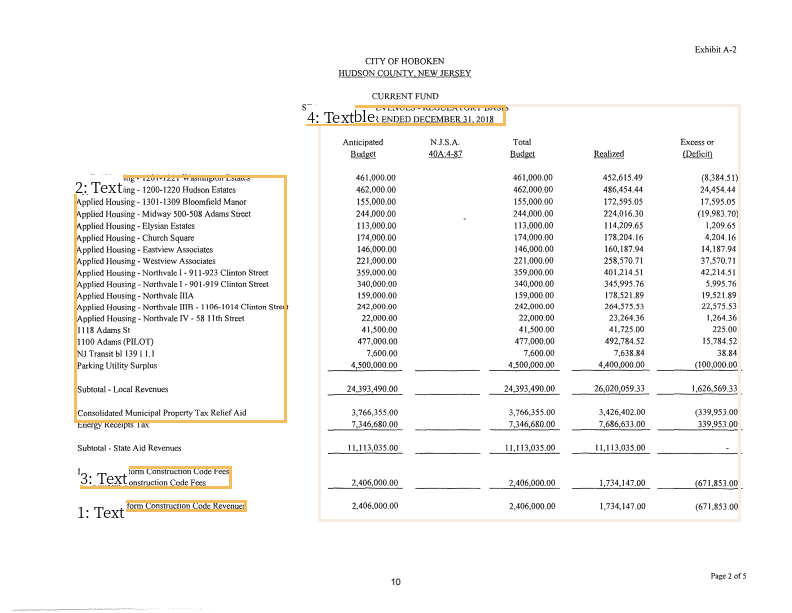

In [33]:
lp.draw_box(image, layout, box_width=3, show_element_type=True,show_element_id=True)
# Show the detected layout of the input image

In [28]:
# print(type(layout))
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=318.2394714355469, y_1=104.01380920410156, x_2=740.0922241210938, y_2=521.8098754882812), text=None, id=None, type=Table, parent=None, next=None, score=0.9839901924133301), TextBlock(block=Rectangle(x_1=77.18082427978516, y_1=500.1070251464844, x_2=246.0209503173828, y_2=511.13348388671875), text=None, id=None, type=Text, parent=None, next=None, score=0.8971920013427734), TextBlock(block=Rectangle(x_1=74.59085845947266, y_1=175.25244140625, x_2=286.3189392089844, y_2=422.6844482421875), text=None, id=None, type=Text, parent=None, next=None, score=0.7553789019584656), TextBlock(block=Rectangle(x_1=80.03667449951172, y_1=466.0499267578125, x_2=231.3678741455078, y_2=488.1468505859375), text=None, id=None, type=Text, parent=None, next=None, score=0.6894283890724182)], page_data={})

In [39]:
image.shape

(613, 792, 3)

In [67]:
title_blocks = lp.Layout([b for b in layout if b.type=='Title'])

text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
table_blocks = lp.Layout([b for b in layout if b.type=='Table'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])
title_blocks, table_blocks, figure_blocks

(Layout(_blocks=[], page_data={}),
 Layout(_blocks=[TextBlock(block=Rectangle(x_1=318.239501953125, y_1=104.01374053955078, x_2=740.0921020507812, y_2=521.809814453125), text=None, id=None, type=Table, parent=None, next=None, score=0.9839903116226196), TextBlock(block=Rectangle(x_1=72.45698547363281, y_1=160.0615997314453, x_2=278.4991455078125, y_2=497.83160400390625), text=None, id=None, type=Table, parent=None, next=None, score=0.09752898663282394)], page_data={}),
 Layout(_blocks=[TextBlock(block=Rectangle(x_1=245.83670043945312, y_1=70.5211181640625, x_2=747.3177490234375, y_2=527.1600952148438), text=None, id=None, type=Figure, parent=None, next=None, score=0.05894118919968605)], page_data={}))

In [34]:
layout_structure={}
for block in layout:
  if block.type in layout_structure:
     layout_structure[block.type].append(block)
  else:
    layout_structure[block.type]=[block]
layout_structure

{'Table': [TextBlock(block=Rectangle(x_1=318.2394714355469, y_1=104.01380920410156, x_2=740.0922241210938, y_2=521.8098754882812), text=None, id=None, type=Table, parent=None, next=None, score=0.9839901924133301)],
 'Text': [TextBlock(block=Rectangle(x_1=77.18082427978516, y_1=500.1070251464844, x_2=246.0209503173828, y_2=511.13348388671875), text=None, id=None, type=Text, parent=None, next=None, score=0.8971920013427734),
  TextBlock(block=Rectangle(x_1=74.59085845947266, y_1=175.25244140625, x_2=286.3189392089844, y_2=422.6844482421875), text=None, id=None, type=Text, parent=None, next=None, score=0.7553789019584656),
  TextBlock(block=Rectangle(x_1=80.03667449951172, y_1=466.0499267578125, x_2=231.3678741455078, y_2=488.1468505859375), text=None, id=None, type=Text, parent=None, next=None, score=0.6894283890724182),
  TextBlock(block=Rectangle(x_1=306.89288330078125, y_1=105.09698486328125, x_2=505.4262390136719, y_2=125.57240295410156), text=None, id=None, type=Text, parent=None, n

In [69]:
label_map={0: "Table"}
model3=lp.models.Detectron2LayoutModel('lp://TableBank/faster_rcnn_R_101_FPN_3x/config',label_map=label_map)

config.yaml?dl=1: 8.19kB [00:01, 4.71kB/s]
model_final.pth?dl=1: 482MB [00:10, 45.5MB/s]                           
/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on 

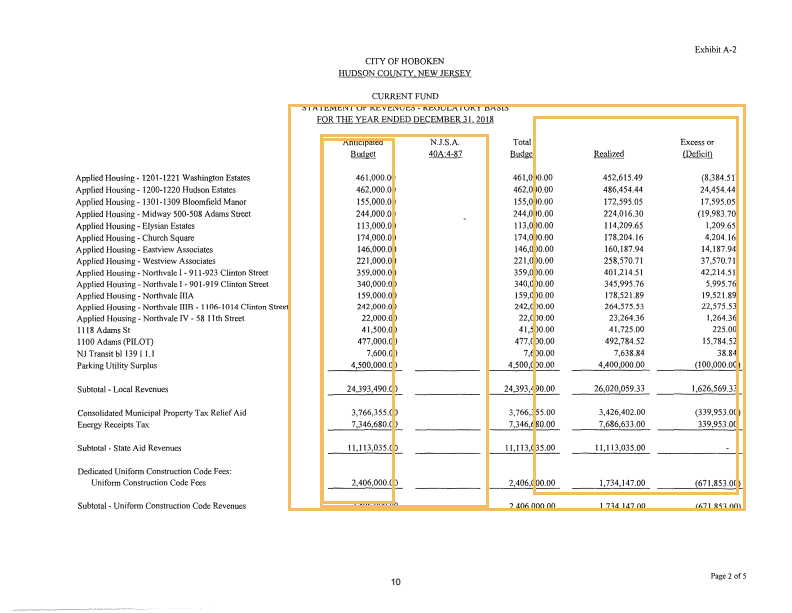

In [71]:
layout3=model3.detect(image)
lp.draw_box(image, layout3, box_width=3)

In [53]:
%%time
model2 = lp.models.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                #  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", threshold],
                                 label_map=label_map
                                        )

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


CPU times: user 2.36 s, sys: 798 ms, total: 3.15 s
Wall time: 3.74 s


CPU times: user 16.7 s, sys: 1.31 s, total: 18 s
Wall time: 18.1 s


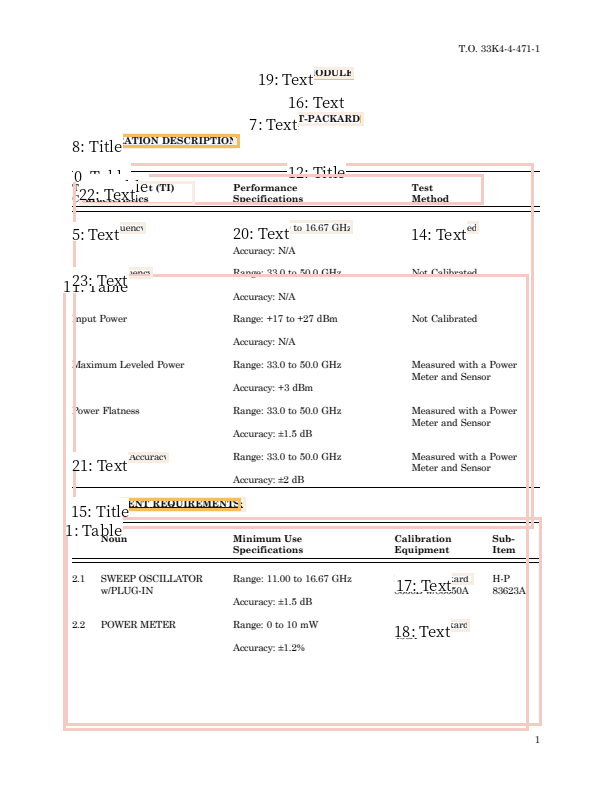

In [54]:
%%time
layout2=model2.detect(image)
lp.draw_box(image, layout2, box_width=3, show_element_type=True,show_element_id=True)


In [55]:
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=318.2394714355469, y_1=104.01380920410156, x_2=740.0922241210938, y_2=521.8098754882812), text=None, id=None, type=Table, parent=None, next=None, score=0.9839901924133301), TextBlock(block=Rectangle(x_1=77.18082427978516, y_1=500.1070251464844, x_2=246.0209503173828, y_2=511.13348388671875), text=None, id=None, type=Text, parent=None, next=None, score=0.8971920013427734), TextBlock(block=Rectangle(x_1=74.59085845947266, y_1=175.25244140625, x_2=286.3189392089844, y_2=422.6844482421875), text=None, id=None, type=Text, parent=None, next=None, score=0.7553789019584656), TextBlock(block=Rectangle(x_1=80.03667449951172, y_1=466.0499267578125, x_2=231.3678741455078, y_2=488.1468505859375), text=None, id=None, type=Text, parent=None, next=None, score=0.6894283890724182), TextBlock(block=Rectangle(x_1=306.89288330078125, y_1=105.09698486328125, x_2=505.4262390136719, y_2=125.57240295410156), text=None, id=None, type=Text, parent=None, next=None, sc

In [60]:
for block in layout:
  print(block.to_dict())

{'x_1': 318.2394714355469, 'y_1': 104.01380920410156, 'x_2': 740.0922241210938, 'y_2': 521.8098754882812, 'block_type': 'rectangle', 'type': 'Table', 'score': 0.9839901924133301}
{'x_1': 77.18082427978516, 'y_1': 500.1070251464844, 'x_2': 246.0209503173828, 'y_2': 511.13348388671875, 'block_type': 'rectangle', 'type': 'Text', 'score': 0.8971920013427734}
{'x_1': 74.59085845947266, 'y_1': 175.25244140625, 'x_2': 286.3189392089844, 'y_2': 422.6844482421875, 'block_type': 'rectangle', 'type': 'Text', 'score': 0.7553789019584656}
{'x_1': 80.03667449951172, 'y_1': 466.0499267578125, 'x_2': 231.3678741455078, 'y_2': 488.1468505859375, 'block_type': 'rectangle', 'type': 'Text', 'score': 0.6894283890724182}
{'x_1': 306.89288330078125, 'y_1': 105.09698486328125, 'x_2': 505.4262390136719, 'y_2': 125.57240295410156, 'block_type': 'rectangle', 'type': 'Text', 'score': 0.4451189637184143}


In [61]:
layout.to_dataframe()

x_1         y_1         x_2         y_2 block_type   type     score
0  318.239471  104.013809  740.092224  521.809875  rectangle  Table  0.983990
1   77.180824  500.107025  246.020950  511.133484  rectangle   Text  0.897192
2   74.590858  175.252441  286.318939  422.684448  rectangle   Text  0.755379
3   80.036674  466.049927  231.367874  488.146851  rectangle   Text  0.689428
4  306.892883  105.096985  505.426239  125.572403  rectangle   Text  0.445119

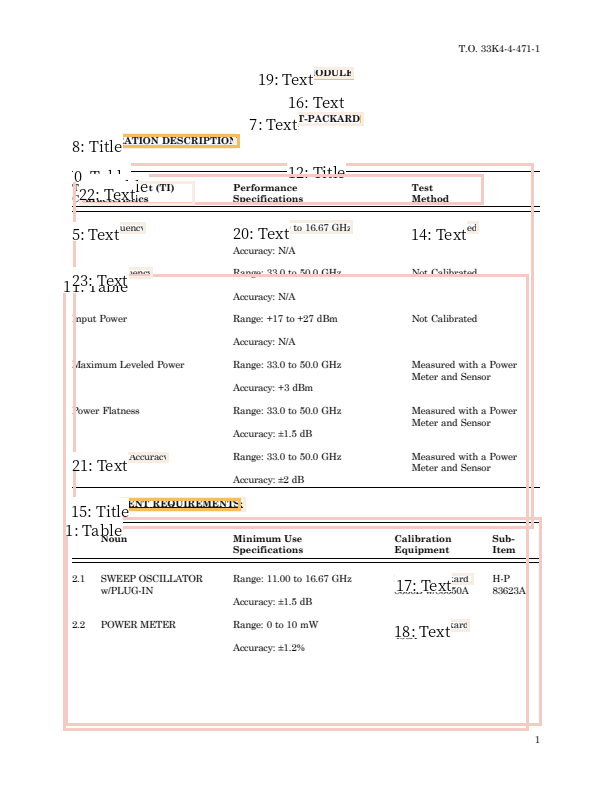

In [59]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)
lp.draw_box(image, layout2, box_width=3, show_element_type=True,show_element_id=True)


In [30]:
title_blocks = lp.Layout([b for b in layout if b.type=='Title'])

text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
table_blocks = lp.Layout([b for b in layout if b.type=='Table'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])
title_blocks, table_blocks, figure_blocks

(Layout(_blocks=[TextBlock(block=Rectangle(x_1=56.99232482910156, y_1=62.11664962768555, x_2=309.74261474609375, y_2=88.01103973388672), text=None, id=None, type=Title, parent=None, next=None, score=0.96590256690979), TextBlock(block=Rectangle(x_1=54.777931213378906, y_1=658.819580078125, x_2=138.41648864746094, y_2=669.71630859375), text=None, id=None, type=Title, parent=None, next=None, score=0.9629741311073303)], page_data={}),
 Layout(_blocks=[], page_data={}),
 Layout(_blocks=[TextBlock(block=Rectangle(x_1=54.38372802734375, y_1=300.068603515625, x_2=582.0956420898438, y_2=569.5838012695312), text=None, id=None, type=Figure, parent=None, next=None, score=0.7619624733924866)], page_data={}))

In [29]:
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=55.026859283447266, y_1=109.20268249511719, x_2=191.73834228515625, y_2=120.96406555175781), text=None, id=None, type=Text, parent=None, next=None, score=0.9978085160255432), TextBlock(block=Rectangle(x_1=52.678401947021484, y_1=669.6392211914062, x_2=319.58221435546875, y_2=698.7954711914062), text=None, id=None, type=Text, parent=None, next=None, score=0.9117313623428345), TextBlock(block=Rectangle(x_1=54.751930236816406, y_1=688.6851196289062, x_2=210.890380859375, y_2=699.5033569335938), text=None, id=None, type=Text, parent=None, next=None, score=0.7723374366760254), TextBlock(block=Rectangle(x_1=55.25188446044922, y_1=130.07786560058594, x_2=116.56348419189453, y_2=142.70936584472656), text=None, id=None, type=Text, parent=None, next=None, score=0.7466012239456177)], page_data={})

In [31]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=55.026859283447266, y_1=109.20268249511719, x_2=191.73834228515625, y_2=120.96406555175781), text=None, id=None, type=Text, parent=None, next=None, score=0.9978085160255432), TextBlock(block=Rectangle(x_1=52.678401947021484, y_1=669.6392211914062, x_2=319.58221435546875, y_2=698.7954711914062), text=None, id=None, type=Text, parent=None, next=None, score=0.9117313623428345), TextBlock(block=Rectangle(x_1=54.751930236816406, y_1=688.6851196289062, x_2=210.890380859375, y_2=699.5033569335938), text=None, id=None, type=Text, parent=None, next=None, score=0.7723374366760254), TextBlock(block=Rectangle(x_1=55.25188446044922, y_1=130.07786560058594, x_2=116.56348419189453, y_2=142.70936584472656), text=None, id=None, type=Text, parent=None, next=None, score=0.7466012239456177)], page_data={})

In [ ]:
opencvImage = cv2.cvtColor(numpy.array(pre), cv2.COLOR_RGB2BGR)

In [40]:
type(image)

numpy.ndarray

In [36]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])#, inplace=True)

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])#, inplace=True)

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

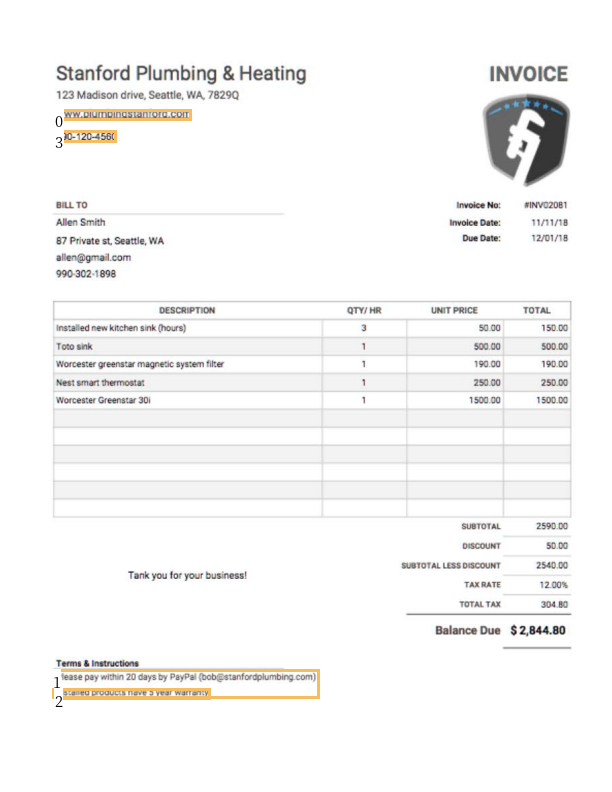

In [40]:
lp.draw_box(image, text_blocks,
            box_width=3,
            show_element_id=True)

In [41]:
ocr_agent = lp.TesseractAgent(languages='eng')


In [42]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [49]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')


---
‘rease pay within 20 days by PayPal (bob@stanforeplumbing com)
Instaed products have S year warrsty

---
Ingzalied products have 5 year warranty.

---
(990-120-4560

---


In [48]:
help(text_blocks.get_texts)

Help on method get_texts in module layoutparser.elements:

get_texts() method of layoutparser.elements.Layout instance
    Iterate through all the text blocks in the list and append their ocr'ed text results.
    
    Returns:
        :obj:`List[str]`: A list of text strings of the text blocks in the list of layout elements.



In [42]:
print(type(page_table_imgs[0]))
cvImage = cv2.cvtColor(np.array(page_table_imgs[0]), cv2.COLOR_RGB2BGR)
type(cvImage)

<class 'PIL.Image.Image'>


numpy.ndarray

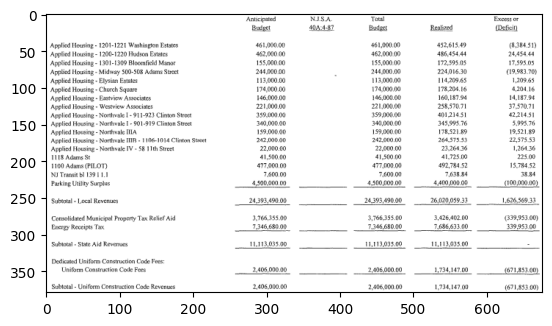

In [46]:
plt.imshow(cvImage)

In [43]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [44]:
%%time
res = ocr_agent.detect(cvImage, return_response=True)
res

CPU times: user 131 ms, sys: 12.5 ms, total: 143 ms
Wall time: 10 s


{'text': 'Appi Heng 1201-1224 Washington Estates\n‘Ale Housing 1206-1220 Hadi Estes\nAppl Housing 1301-309 Blend Mee\nAppi Housing Midway S050 Acans Sect\n‘Apple Howsing- Elysian Estes\n\n‘Apple Howsing Chueh Sq\n\n‘Aled Howsing- Eastview Asoc\n\n‘ple Hoaing - Wesvew Ascites\n\n‘Applet Hoang Novae 911-923 Clann Stet\nAppi Howsing- Neral IA\n\n‘opti Housing. Neral Y= 8118 Stet\n1100 Adams PLOT\n\nNv Teae 6 19\n\nPking Uy Sapis\n\n \n\n \n\nSeta -Lozal Reena\n\nConoled Mail opr Tex Rot Aid\nEng Ress Ts\n\nSub - Ste Aid Revers\n\noti Ufo Cancion Cade Fees\n‘Unto Consrston Coe Pers\n\n‘Subtotal - Uniform Construction Code Revenues\n\nAnticipated\nBoise\n\n461.0000\n‘48200000\n1ssong0\n24400000\n113,000.00\n1400000\n14500000\n22190000\n33900000,\n139.0000\n7200000\n4130000\nsrronaon\n7.00.00\n4sa0.00000,\n\n2439.40 00\n\n2376638800\n134669000\n\n11130350\n\n240600000,\n\n200690000\n\n‘at,\n\n161,000.00\n‘46,0000\n1850000\n2440.00\n113.000.00\n17400000\nsoon 00\n100.00\n5350000\n$3,000.00\n1

In [59]:
res['data'].query('conf>0')

level  page_num  block_num  par_num  line_num  word_num  left  top  \
4        5         1          1        1         1         1     6   29   
5        5         1          1        1         1         2    36   41   
6        5         1          1        1         1         3    73   40   
8        5         1          1        1         1         5   156   29   
10       5         1          1        1         2         1     2   41   
..     ...       ...        ...      ...       ...       ...   ...  ...   
367      5         1         34        2        10         1   637  180   
369      5         1         34        2        11         1   633  203   
373      5         1         35        1         1         1   625  227   
383      5         1         37        1         2         1   628  287   
387      5         1         38        1         1         1   628  346   

     width  height  conf       text  
4       24      28    51       Appi  
5       27       8    23       Heng  
6       15       7    53  1201-1224  
8       26      28    49    Estates  
10      31      28    40       ‘Ale  
..     ...     ...   ...        ...  
367     30       7    81     126436  
369     34       8    26        isu  
373     42       8    64   10000000  
383     40       7    46   53895300  
387     45       9    63  (7185300)  

[158 rows x 12 columns]

In [60]:
res['data']['block_num'].value_counts()

block_num
1     87
17    36
26    33
10    32
34    31
5     13
7     13
8      9
6      8
38     6
9      6
4      6
37     6
12     6
11     5
25     4
35     4
33     4
32     4
36     4
31     4
30     4
29     4
28     4
27     4
19     4
24     4
23     4
22     4
21     4
20     4
18     4
16     4
15     4
14     4
13     4
3      4
2      4
0      1
Name: count, dtype: int64

In [56]:
data=ocr_agent.gather_data(res,agg_level=5)
data

AssertionError: Invalid agg_level 5

In [ ]:
image_width = len(cvImage[0])

# Sort element ID of the left column based on y1 coordinate
left_interval = lp.Interval(0, image_width/2, axis='x').put_on_canvas(img)
left_blocks = text_blocks1.filter_by(left_interval, center=True)._blocks
left_blocks.sort(key = lambda b:b.coordinates[1])

# Sort element ID of the right column based on y1 coordinate
right_blocks = [b for b in text_blocks1 if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# Sort the overall element ID starts from left column
text_blocks1 = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng')

for block in text_blocks1:

    # Crop image around the detected layout
    segment_image = (block
                       .pad(left=15, right=15, top=5, bottom=5)
                       .crop_image(img))

    # Perform OCR
    text = ocr_agent.detect(segment_image)

    # Save OCR result
    block.set(text=text, inplace=True)

## Post-process data

In [ ]:
text = text.replace("-\n", "")

In [ ]:
import re
subt = 0
amt_re = re.compile(r'\.\d\d$')
for line in lines:
    if 'SUBTOTAL' in line:
        break
    if amt_re.search(line):
        subt += float(line.split()[-1].replace(',', '').replace('$', ''))